# Exploratory Data Analysis


In this notebook, we explore all variables present in the on-time on-performance flight data for years 2015-2016 which is merged with weather datasets at top 20 airports (in terms of number of flights operating) in the US.  

## Loading modules

In [1051]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [554]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [555]:
pd.set_option('display.max_columns', None)

## Loading the data

We already acquired the flight data from the [Bureau of Transportation Statisitcs](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time), and engineered some interesting features about flight's historical performance. The flight data with historical information was then merged with [weather datasets](https://www.wunderground.com/weather/api) at top 20 US airports. Details about the data acquisition and merging can be found in this notebook: /springboard-datascience-intensive/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb. After merging the data sets, we also performed some cleaning to take care of missing values. Details about the data cleaning can be found in this notebook: /springboard-datascience-intensive/capstone_project/DataCleaning/data_cleaning.ipynb. 

So, after running that python notebook (data_cleaning.ipynb), we get the following csv file, which we can load for EDA now.   

In [556]:
df = pd.read_csv("../Data/CleanedData/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Cleaned.csv")

In [557]:
df.shape

(2857139, 92)

In [558]:
df.head()

Unnamed: 0  Year  Quarter  Month  DayofMonth  DayOfWeek Carrier Origin  \
0           0  2015        1      1           1          4      AA    PHX   
1           1  2015        1      1           1          4      NK    PHX   
2           2  2015        1      1           1          4      DL    DEN   
3           3  2015        1      1           1          4      NK    LAS   
4           4  2015        1      1           1          4      NK    LAS   

  OriginCityName OriginState  OriginWac Dest           DestCityName DestState  \
0    Phoenix, AZ          AZ         81  DFW  Dallas/Fort Worth, TX        TX   
1    Phoenix, AZ          AZ         81  DFW  Dallas/Fort Worth, TX        TX   
2     Denver, CO          CO         82  ATL            Atlanta, GA        GA   
3  Las Vegas, NV          NV         85  MSP        Minneapolis, MN        MN   
4  Las Vegas, NV          NV         85  DFW  Dallas/Fort Worth, TX        TX   

   DestWac  CRSDepTime DepTimeBlk  CRSArrTime ArrTimeBlk  Cancelled  Diverted  \
0       74         200  0001-0559         500  0001-0559        1.0       0.0   
1       74         159  0001-0559         502  0001-0559        0.0       0.0   
2       34          30  0001-0559         523  0001-0559        0.0       0.0   
3       63          25  0001-0559         526  0001-0559        0.0       0.0   
4       74         103  0001-0559         530  0001-0559        0.0       0.0   

   Distance  DistanceGroup  DivAirportLandings  Nflights_10  \
0     868.0              4                   0           10   
1     868.0              4                   0            0   
2    1199.0              5                   0           17   
3    1299.0              6                   0            0   
4    1055.0              5                   0            0   

   DepDelayMedian_10  DepDelayMax_10  ArrDelayMedian_10  ArrDelayMax_10  \
0               -2.0             0.0               -2.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -5.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_10  TaxiInMedian_10  Ncan_10  Ndiv_10  Nflights_20  \
0              13.0              4.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              17.0              7.0      0.0      0.0           21   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_20  DepDelayMax_20  ArrDelayMedian_20  ArrDelayMax_20  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -7.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_20  TaxiInMedian_20  Ncan_20  Ndiv_20  Nflights_30  \
0              13.0              5.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              15.0              7.0      0.0      0.0           21   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_30  DepDelayMax_30  ArrDelayMedian_30  ArrDelayMax_30  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -7.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0 

In [559]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

We plan to use 2015 data for training the machine learning model and 2016 for evaluating performance, i.e. for testing. Therefore, we decide to consider only 2015 data for exploratory data analysis too. Before filtering the data frame, lets see how many records do we have for each year?

In [560]:
print("Total records: ", len(df))
print("Records for 2015: ", sum(df.Year == 2015))
print("Records for 2016: ", sum(df.Year == 2016))

Total records:  2857139
Records for 2015:  1417308
Records for 2016:  1439831


In [561]:
(1439831 - 1417308)/1417308

0.015891394107702773

The difference in number of records is roughly about 23500. In other words, there was about 1.6% increase in number of flights from 2015 to 2016. This much of difference is not that significant to make decision about not splitting the data into 2015 data and 2016 data. So, lets filter the data frame to contain flights only for 2015. Once we go through the whole exploration of 2015 data and achieve some other data frame (probably more cleaned, with more features), we will perform those same steps with 2016 data to be compatible in the machine leanring stage.

## Filtering data frame to contain only year 2015 data

In [562]:
df = df[df.Year == 2015]

In [563]:
df.head()

Year  Quarter  Month  DayofMonth  DayOfWeek Carrier Origin OriginCityName  \
0  2015        1      1           1          4      AA    PHX    Phoenix, AZ   
1  2015        1      1           1          4      NK    PHX    Phoenix, AZ   
2  2015        1      1           1          4      DL    DEN     Denver, CO   
3  2015        1      1           1          4      NK    LAS  Las Vegas, NV   
4  2015        1      1           1          4      NK    LAS  Las Vegas, NV   

  OriginState  OriginWac Dest           DestCityName DestState  DestWac  \
0          AZ         81  DFW  Dallas/Fort Worth, TX        TX       74   
1          AZ         81  DFW  Dallas/Fort Worth, TX        TX       74   
2          CO         82  ATL            Atlanta, GA        GA       34   
3          NV         85  MSP        Minneapolis, MN        MN       63   
4          NV         85  DFW  Dallas/Fort Worth, TX        TX       74   

   CRSDepTime DepTimeBlk  CRSArrTime ArrTimeBlk  Cancelled  Diverted  \
0         200  0001-0559         500  0001-0559        1.0       0.0   
1         159  0001-0559         502  0001-0559        0.0       0.0   
2          30  0001-0559         523  0001-0559        0.0       0.0   
3          25  0001-0559         526  0001-0559        0.0       0.0   
4         103  0001-0559         530  0001-0559        0.0       0.0   

   Distance  DistanceGroup  DivAirportLandings  Nflights_10  \
0     868.0              4                   0           10   
1     868.0              4                   0            0   
2    1199.0              5                   0           17   
3    1299.0              6                   0            0   
4    1055.0              5                   0            0   

   DepDelayMedian_10  DepDelayMax_10  ArrDelayMedian_10  ArrDelayMax_10  \
0               -2.0             0.0               -2.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -5.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_10  TaxiInMedian_10  Ncan_10  Ndiv_10  Nflights_20  \
0              13.0              4.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              17.0              7.0      0.0      0.0           21   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_20  DepDelayMax_20  ArrDelayMedian_20  ArrDelayMax_20  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -7.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_20  TaxiInMedian_20  Ncan_20  Ndiv_20  Nflights_30  \
0              13.0              5.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              15.0              7.0      0.0      0.0           21   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_30  DepDelayMax_30  ArrDelayMedian_30  ArrDelayMax_30  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2               -1.0            48.0               -7.0            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_30  TaxiInMedian_30  Ncan_30  Ndiv_

In [564]:
# just in cast the index got messed up after filtering
df = df.reset_index()
df = df.drop("index", axis=1)

In [565]:
df.shape

(1417308, 91)

There were close to 1.4  million flights in 2015 operating to-and-from the following selected 20 airports.

In [566]:
df[["Origin", "OriginCityName"]].drop_duplicates().sort_values("Origin").set_index("Origin")

OriginCityName
Origin                       
ATL               Atlanta, GA
BOS                Boston, MA
BWI             Baltimore, MD
CLT             Charlotte, NC
DEN                Denver, CO
DFW     Dallas/Fort Worth, TX
DTW               Detroit, MI
EWR                Newark, NJ
IAH               Houston, TX
JFK              New York, NY
LAS             Las Vegas, NV
LAX           Los Angeles, CA
LGA              New York, NY
MCO               Orlando, FL
MSP           Minneapolis, MN
ORD               Chicago, IL
PHX               Phoenix, AZ
SEA               Seattle, WA
SFO         San Francisco, CA
SLC        Salt Lake City, UT

We can also visualize these airports on map.

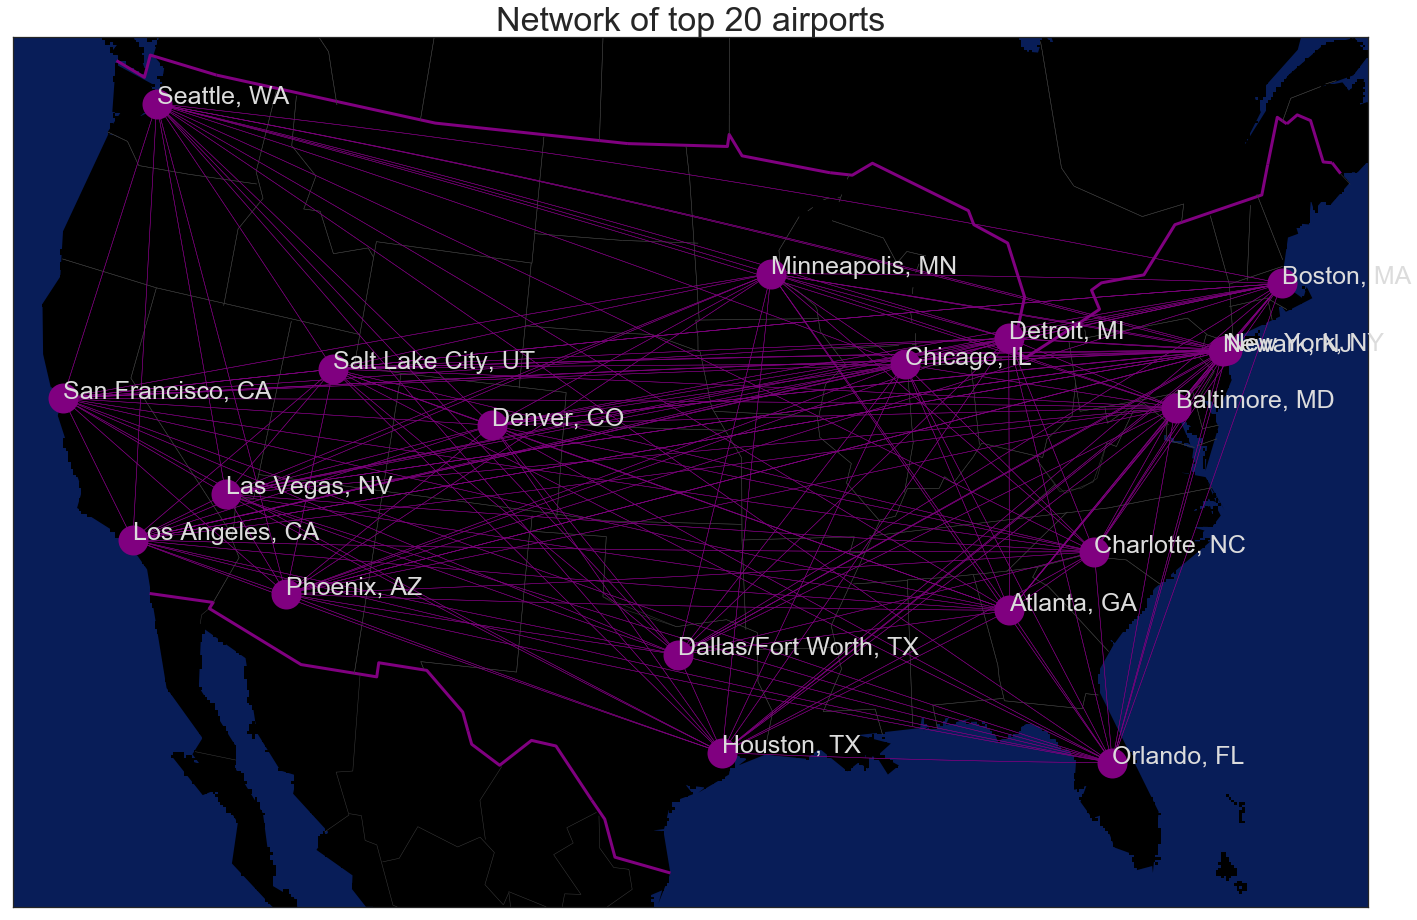

In [567]:
airports = list(set(df.Origin))
cities = list(set(df.OriginCityName))

scale = 1
airports_map = cities.copy()#airports.copy()
# Fixing some airport names for the map
#airports_map[4] = "BWI MD"
#airports_map[5] = "Denver airport"
#airports_map[7] = "ATL GA"
#airports_map[8] = "Boston airport"

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

plt.figure(figsize=(26,16))
m.bluemarble()
#m.shadedrelief()
m.drawcountries(linewidth=3, linestyle='solid', color="purple")
m.drawlsmask(land_color='black',ocean_color=(8/255.0, 29/255.0, 88/255.0), lakes=True)
m.fillcontinents(color="black", lake_color="black")
m.drawstates(color=(60/255.0, 60/255.0, 60/255.0))
# Get the location of each city and plot it
geolocator = Nominatim()
i = 0
latlist = []
lonlist = []
for airport in airports_map:
        loc = geolocator.geocode(airport)
        if not loc:
            print("Could not locate {}".format(airport))
            continue
        x, y = m(loc.longitude, loc.latitude)
        latlist.append(loc[1][0])
        lonlist.append(loc[1][1])
        #m.plot(x,y,marker='o',color=tableau20[12],markersize=30)
        m.plot(x,y,marker='o',color="purple",markersize=30)
        plt.annotate(cities[i], xy = (x,y), size=25, color=(220/255.0, 220/255.0, 220/255.0))
        i = i + 1
for j in np.arange(len(latlist)):
    lat1 = latlist[j]
    lon1 = lonlist[j]
    for k in np.arange(len(latlist)):
        lat2 = latlist[k]
        lon2 = lonlist[k]
        m.drawgreatcircle(lon1, lat1, lon2, lat2, linewidth=0.5, color='purple')
plt.title("Network of top 20 airports", size = 34)
plt.show()

These 20 airports network broadly covers the whole US. Note that due to close proximity, we are not able to distinguish LGA, JFK and EWR airports around New York City. The justification for selecting these 20 airports is discussed in detail in data_acquisition_merging.ipynb notebook. In nutshell, we could get the weather data for only few airports due to weather API limitations. So, we selected top 20 airports that observe highest landings and takeoffs in the US.

Discussing the data frame further, we have 90 columns. Though we have already taken care of all the missing values in the data cleaning step, let us calculate the fraction of nulls (or missing values), just to make sure.

In [568]:
frac_nulls = {col: (sum(df[col].isnull())/len(df)) for col in df.columns}
frac_nulls = sorted(frac_nulls.items(), key = operator.itemgetter(1))
frac_nulls

[('Year', 0.0),
 ('Quarter', 0.0),
 ('Month', 0.0),
 ('DayofMonth', 0.0),
 ('DayOfWeek', 0.0),
 ('Carrier', 0.0),
 ('Origin', 0.0),
 ('OriginCityName', 0.0),
 ('OriginState', 0.0),
 ('OriginWac', 0.0),
 ('Dest', 0.0),
 ('DestCityName', 0.0),
 ('DestState', 0.0),
 ('DestWac', 0.0),
 ('CRSDepTime', 0.0),
 ('DepTimeBlk', 0.0),
 ('CRSArrTime', 0.0),
 ('ArrTimeBlk', 0.0),
 ('Cancelled', 0.0),
 ('Diverted', 0.0),
 ('Distance', 0.0),
 ('DistanceGroup', 0.0),
 ('DivAirportLandings', 0.0),
 ('Nflights_10', 0.0),
 ('DepDelayMedian_10', 0.0),
 ('DepDelayMax_10', 0.0),
 ('ArrDelayMedian_10', 0.0),
 ('ArrDelayMax_10', 0.0),
 ('TaxiOutMedian_10', 0.0),
 ('TaxiInMedian_10', 0.0),
 ('Ncan_10', 0.0),
 ('Ndiv_10', 0.0),
 ('Nflights_20', 0.0),
 ('DepDelayMedian_20', 0.0),
 ('DepDelayMax_20', 0.0),
 ('ArrDelayMedian_20', 0.0),
 ('ArrDelayMax_20', 0.0),
 ('TaxiOutMedian_20', 0.0),
 ('TaxiInMedian_20', 0.0),
 ('Ncan_20', 0.0),
 ('Ndiv_20', 0.0),
 ('Nflights_30', 0.0),
 ('DepDelayMedian_30', 0.0),
 ('DepDela

We do not have any column with any missing values, which is great. Details about each column can be found [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) and [here](https://www.wunderground.com/weather/api/d/docs?d=resources/phrase-glossary) and some in /springboard-datascience-intensive/capstone_project/DataAcquisitionMerging/history_calc.ipynb and /springboard-datascience-intensive/capstone_project/DataCleaning/data_cleaning.ipynb. The "Cancelled" column has two values: 1 for canceled flights and 0 for not-canceled flights. What is the fraction of those 1.4+ million flights (at 20 airports) that got canceled in the year 2015? 

In [569]:
print(100*sum(df.Cancelled == 1)/len(df), "% of the total flights were cancelled in the year 2015 at top 20 airports in the US.")

1.28497122714 % of the total flights were cancelled in the year 2015 at top 20 airports in the US.


This does not seem like a large number but such rare events cause a lot of troubles to passengers, and cost lot of money to airline industries. So, it is very important to predict the likelihood of even such rare events. Let us visualize the total number of flight cancellations on a daily basis.

In [570]:
# FlightDateTime is the scheduled date and time of the flight at the origin airport 
df["FlightDateTime"] = pd.to_datetime(df["FlightDateTime"])

In [571]:
# a function to remove top and right borders from plots
def hide_topright(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

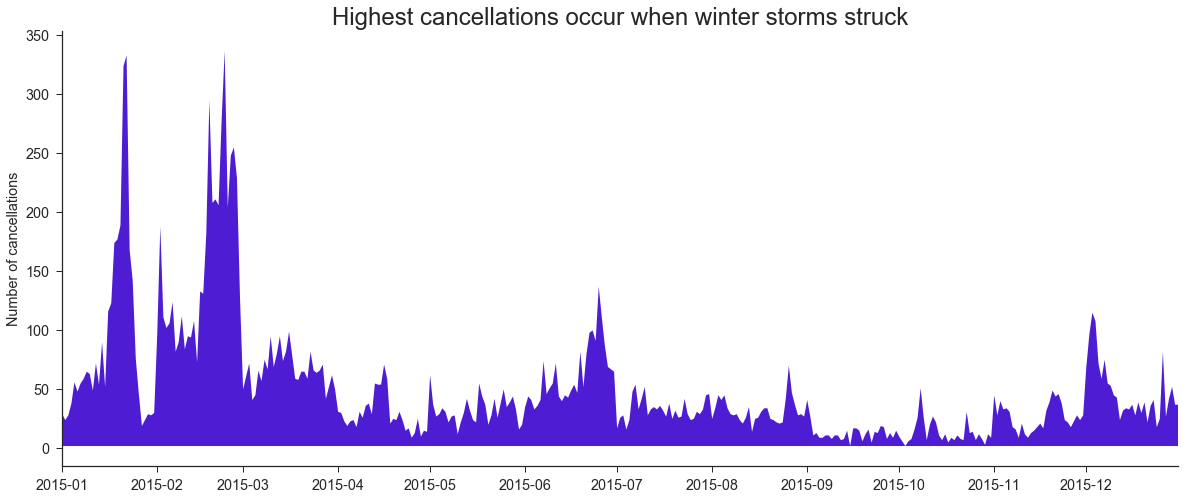

In [588]:
fig, ax = plt.subplots(figsize=(20,8))
d = df.groupby(df.set_index("FlightDateTime").index.date)["Cancelled"].sum()
#d = df.groupby(["FlightDateTime"])["Cancelled"].sum()
ax.fill_between(d.index, d.values, np.min(d.values), 
                facecolor=(78/255.0, 29/255.0, 211/255.0), linewidth =0.5)
#ax.annotate('East coast blizzard, Jan 27, 2015', xy=('2015-01-27', 1020), xytext=('2015-02-05', 1050), size=18,
#           arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#ax.annotate('North east snow storm, Feb 02, 2015', xy=('2015-02-02', 720), xytext=('2015-02-15', 850), size=18,
#           arrowprops=dict(facecolor='black', shrink=0.05),
#            )
plt.title("Highest cancellations occur when winter storms struck", size=24)
hide_topright(ax)
#plt.gca().invert_yaxis()
plt.xlim(('2015-01-01', '2015-12-31'))
#plt.ylim((0, 350))
plt.ylabel("Number of cancellations")

Big spikes in the number of flight cancellations are mainly caused by bad weather as depicted above. There were thousands of flights that were being canceled within a single day, at some days. However, here we do not have such big numbers as the data contains only 20 airports. In any case, we do see a trend. There are some spikes in cancellation activities in the end of June and begining of December too.

## Exploring all columns

Let us now explore the relationships between cancellation rate and all other variables that we have in the data frame. There are broadly three kinds of data in our data frame.

1. Flight data

2. Flight historical performance data

3. Weather data

Going forward from the plot above, let us first explore the temporal variability for cancellation rates. 


#### Quarter

Lets create a generic function to make plots for cancellation rates by given temporal categorical variable.

In [708]:
def plot_canrate_by_temp_cat(df, by, xlab, ylab, title, ylim, tbl):
    plt.subplots(1, 1, figsize=(15, 2))

    ax = plt.subplot(1, 1, 1)
    (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count()).plot(kind="bar", 
                                                                                         color=tableau20[tbl])    
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.ylim(ylim)
    plt.title(title)
    hide_topright(ax)

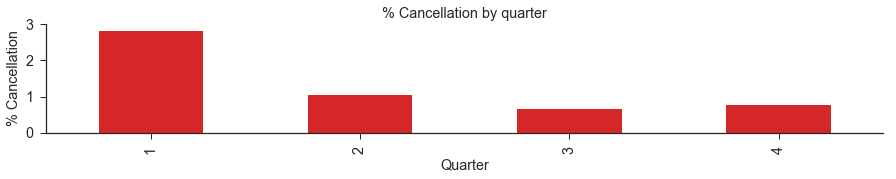

In [709]:
plot_canrate_by_temp_cat(df, "Quarter", "Quarter", "% Cancellation", "% Cancellation by quarter", [0, 3], 6)

The highest rate of cancellation (about 2.7%) is seen in the first quarter. The other quarters have lower and quite similar cancellation rates, about 0.5-1%. The highest rate in the first quarter may be due to the bad weather/winter storms, as also observed in the previous plot. We can zoom-in into the first quarter or all of them by fine-graining this observation, let us see the monthly cancellation rates.

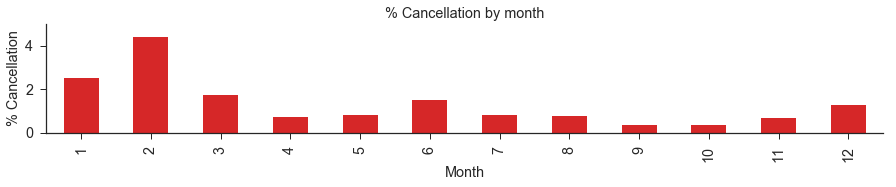

In [650]:
plot_canrate_by_temp_cat(df, "Month", "Month", "% Cancellation", "% Cancellation by month", [0, 5], 6)

February was the worst in the first quarter followed by January anr March. We seee some mild spikes for June and December too. So far we have been thinking that bad weather plays a major role in flight cancellations. We should look at the effect of weather condition on cancellation rate for each quarter or month or even season. Before that lets just plot the cancellation rate by weather condition at the origin and deestination airports for the whole data.    

In [746]:
def plot_canrate_by_cat(df, by, xlab, ylab, title, sort, diffColor, top10, width, height, tbl, xlim, vertline):
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    can_rate = (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count())
    if top10:
        can_rate_sorted = can_rate.sort_values(ascending=True).tail(10)
    else:
        can_rate_sorted = can_rate.sort_values(ascending=True)
    
    total = len(list(can_rate_sorted.index))
    
    if diffColor:
        bottomn = 8
        topn = total - bottomn
        colors = [tableau20[tbl+1]]*topn
        colors = colors + [tableau20[tbl]]*bottomn
    else:
        colors = [tableau20[tbl]]*total
    
    if sort:
        ax = can_rate_sorted.plot(kind='barh',color=colors, zorder=0)
    else:
        ax = can_rate.plot(kind='barh',color=colors, zorder=0)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title, size=20)
    plt.xlim(xlim)
    hide_topright(ax)
    plt.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)
    if vertline:
        plt.axvline(x=10, color="blue", linestyle='--', linewidth=1)
    else:
        pass
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])
    #plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
    #ax.invert_yaxis()
    return(fig)

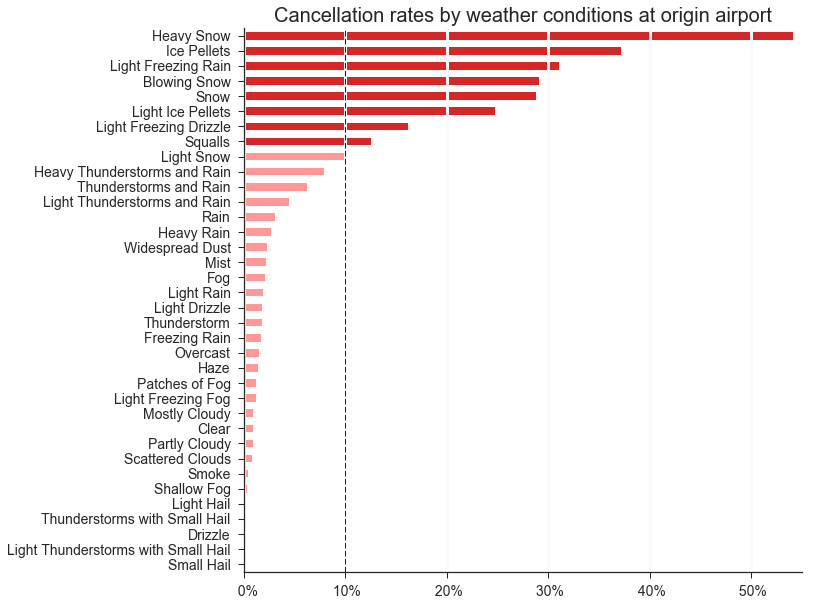

In [747]:
plot_canrate_by_cat(df, "Condition_Origin", "", "", 
                    "Cancellation rates by weather conditions at origin airport", 
                    sort=True, diffColor=True, top10=False, width=10, height=10, tbl=6, xlim=[0, 55], vertline=True);

The cancellation rate here means the total cancellations for a chosen category devided by the total flights for thatsame category. For example, when there was heavy snow at origin airports, about 55% of the flights got cancelled. The dark red bars above indicate when the cancellation rate is more than 10%. We can see that the cancellation rates are pretty high when there is snow related activity. Rain with some thunderstorms also has high cancellation rates.  Interestingly, the cancellation rate is almost 0 when there is any kind of hail. We would expect that there would be disreuptions where are is hail. A possible reason could be that there are very few flights with hail condition at the origin airport.

In [653]:
sum(df.Condition_Origin.str.contains("Hail"))

56

Out of 1.4 million flights, there are only 56 with some type of hail condition. So, we do not have much instances of hail to make any comment about it. Lets now  look at the destination airport weather conditions.

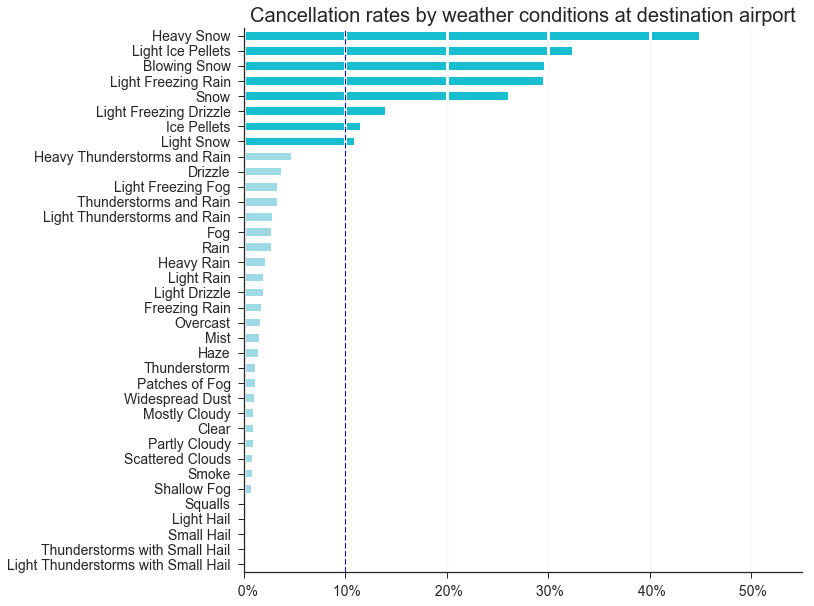

In [748]:
plot_canrate_by_cat(df, "Condition_Dest", "", "", 
                    "Cancellation rates by weather conditions at destination airport", 
                    sort=True, diffColor=True, top10=False, width=10, height=10, tbl=18, xlim=[0, 55], vertline=True);

We observe similar top weather factors where the cancellation rates are high. There is one weather condition called "Squalls" which has very low cancellation rate if that that condition is at destination airport. The same condition has high cancellation rate if it is at origin airport. Again, there could be very small number of instances of "Squalls" to make any comment.

In [655]:
sum(df.Condition_Origin.str.contains("Squalls"))

8

Overall, whenever there are snow or ice related weather events either at origin or destination airports, the cancellation rates are high. However, such conditions occur only in few winter months. We should look at similar plots but for non-winter months too. In order to be precise and save space , we can focus on top 10 weather conditions for which the cancellation rates are high. We can also look at four seasons: winter, spring, summer and falls. 

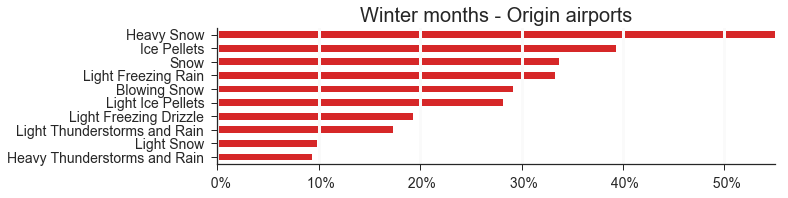

In [749]:
plot_canrate_by_cat(df[df.Month.isin([12,1,2])], "Condition_Origin", "", "", "Winter months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 55], vertline=False);

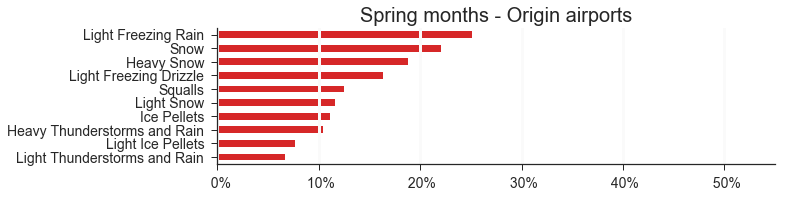

In [750]:
plot_canrate_by_cat(df[df.Month.isin([3,4,5])], "Condition_Origin", "", "", "Spring months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 55], vertline=False);

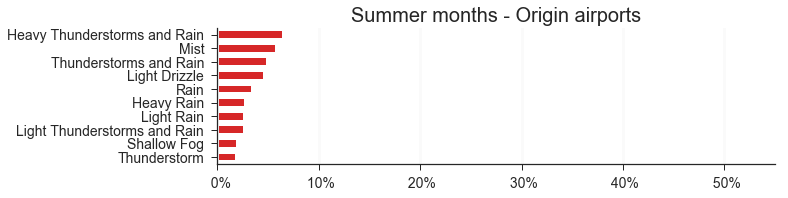

In [751]:
plot_canrate_by_cat(df[df.Month.isin([6,7,8])], "Condition_Origin", "", "", "Summer months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 55], vertline=False);

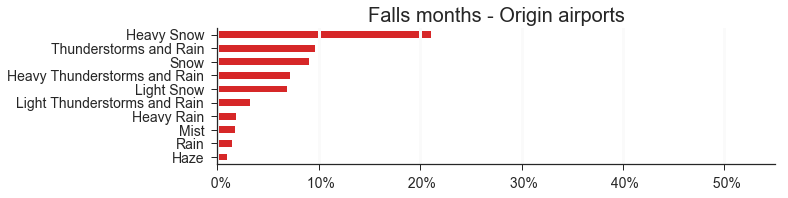

In [752]:
plot_canrate_by_cat(df[df.Month.isin([9,10,11])], "Condition_Origin", "", "", "Falls months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 55], vertline=False);

In summer, thunderstorms and mist have the highest cancellation rates. In all other three seasons, the snow related factors dominate. This means that when there is snow related events in winter, spring or falls then there is high chance of flight cancellations. Also, when there is mist and thunderstorm related events in summer then there is high chance of cancellations. Does this hold true if we look at destination airports? 

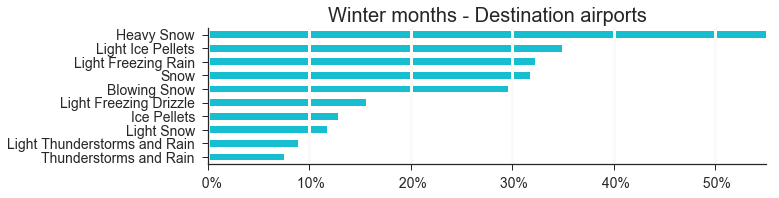

In [753]:
plot_canrate_by_cat(df[df.Month.isin([12,1,2])], "Condition_Dest", "", "", "Winter months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 55], vertline=False);

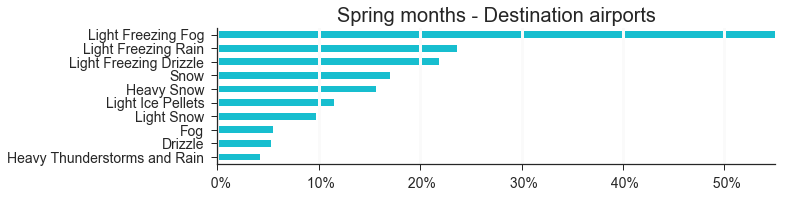

In [754]:
plot_canrate_by_cat(df[df.Month.isin([3,4,5])], "Condition_Dest", "", "", "Spring months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 55], vertline=False);

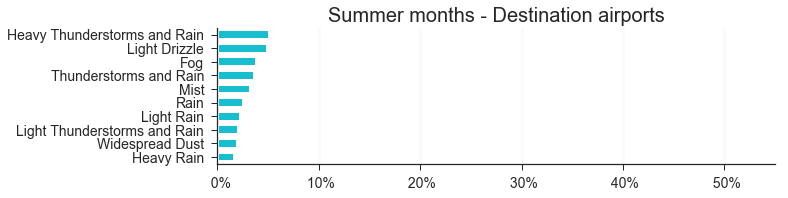

In [755]:
plot_canrate_by_cat(df[df.Month.isin([6,7,8])], "Condition_Dest", "", "", "Summer months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 55], vertline=False);

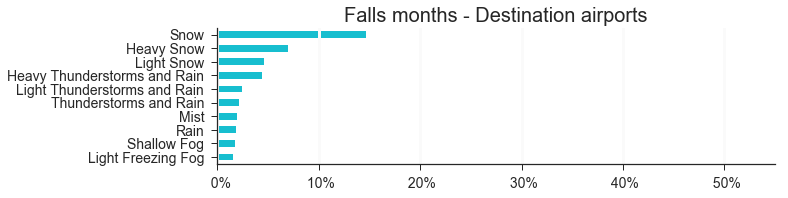

In [756]:
plot_canrate_by_cat(df[df.Month.isin([9,10,11])], "Condition_Dest", "", "", "Falls months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 55], vertline=False);

The story is almost same for destination too. Clearly, both weather factors and months affect the cancellation rates. There is some interaction between months and weather factors. All these high cancellation rates that we saw was for some weather factors which occur quite infrequently as comapred with "Overcast", "Clear" etc. These high frequent weather factors dominate the data and have very low flight cancellation rates. 

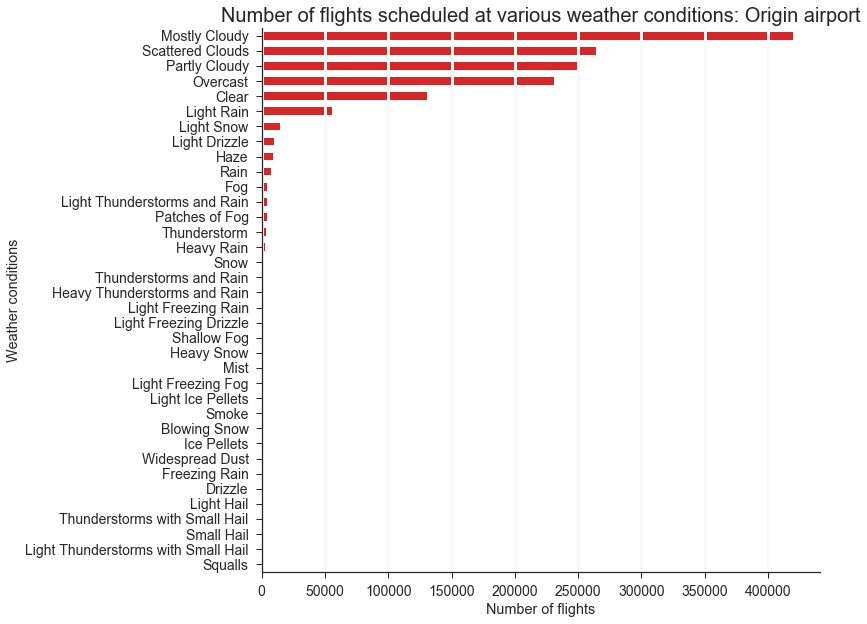

In [757]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.groupby("Condition_Origin")["Condition_Origin"].count().sort_values(ascending=True).plot(kind="barh", 
                                                                                            zorder=0,
                                                                                           color=tableau20[6])
plt.xlabel("Number of flights")
plt.ylabel("Weather conditions")
plt.title("Number of flights scheduled at various weather conditions: Origin airport", size=20)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)

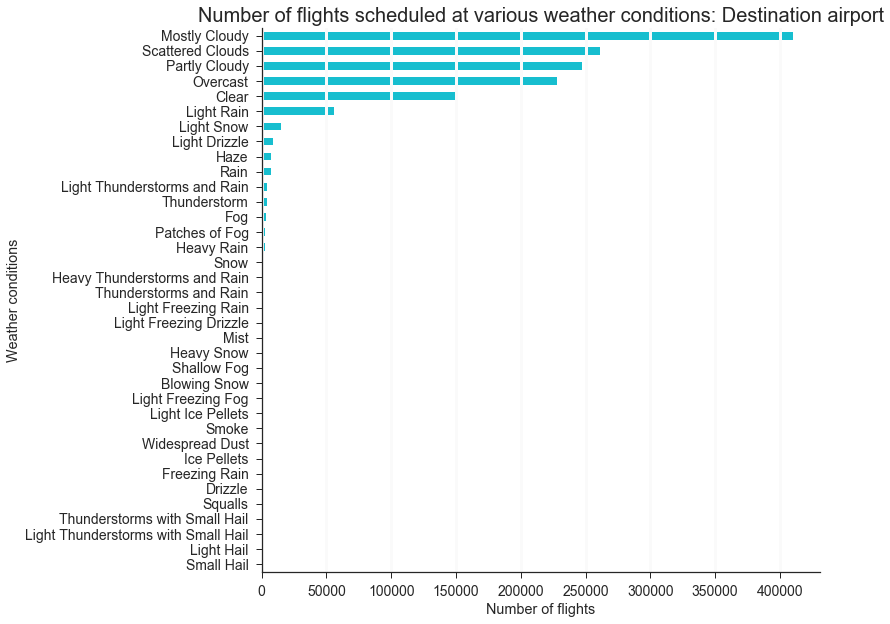

In [758]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.groupby("Condition_Dest")["Condition_Dest"].count().sort_values(ascending=True).plot(kind="barh", 
                                                                                            zorder=0,
                                                                                           color=tableau20[18])
plt.xlabel("Number of flights")
plt.ylabel("Weather conditions")
plt.title("Number of flights scheduled at various weather conditions: Destination airport", size=20)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)

Majority of flights were operated at normal weather conditions such as "Mostly Cloudy", "Scattered Clouds", "Partly Cloudy", "Overcast" and "Clear". At these weather conditions, we found very low cancellations rates. On the other hand, the weather conditions, in which the cancellation rates were pretty high, we see a very small number of flights. 
There are three weather factors: Light Rain, Light Snow, Light Drizzle for which the number of flights are not that low but have considerable cancellation rates in either seasons.

We should keep the weather condition and month data for machine learning modeling. However, since the weather condition data is categorical (and no numerical values), we will create dummy columns to indicate each type of weather condition. We will do this for both origin and destination airport weather conditions. We are postponing this step right now because it will make the data frame bigger and slow down the next analysis calculations. So, we keep this under our TODO list.

***<font color='red' size=5>TODO: Create dummy columns for origin and destination weather conditions</font>***

Moving ahead, lets explore another temporal variable:

#### DayofMonth

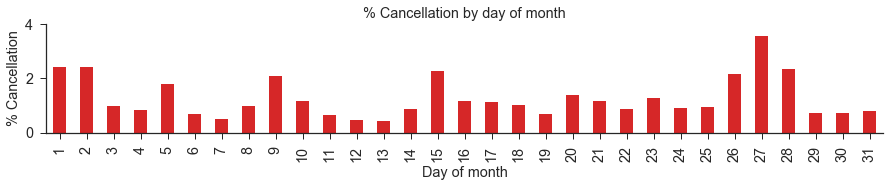

In [759]:
plot_canrate_by_temp_cat(df, "DayofMonth", "Day of month", "% Cancellation", "% Cancellation by day of month", [0, 4], 6)

There seems to be more cancellation in the last week of the month, however the trend is not very clear. We may omit this factor in any further analysis.

#### DayOfWeek

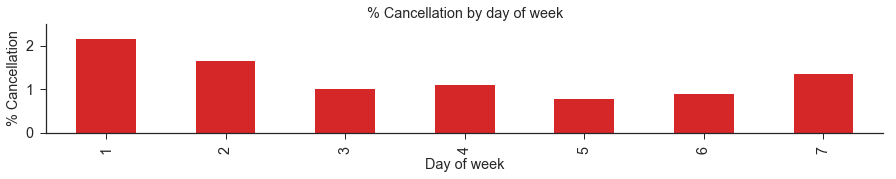

In [760]:
plot_canrate_by_temp_cat(df, "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week", [0, 2.5], 6)

Here, 1 is for Monday. The lowest cancellation rate (less than 1%) is seen beetween Wednesday to Saturday. From Sunday onwards the rate increases and peaks on Monday to about 2.2%, and then drops on coming days. We can definitely keep "DayOfWeek" for future analysis.

Do we see the same weekly trend in all seasons? The above chart is for the whole data, lets create a similar figure for winter months and see if the trend changes.

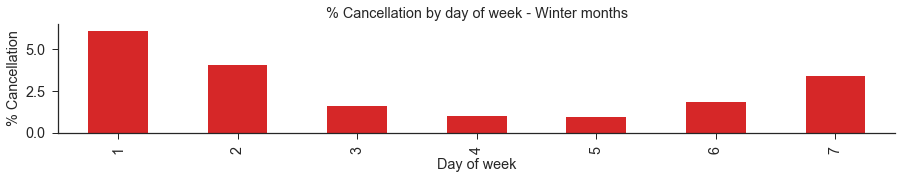

In [761]:
plot_canrate_by_temp_cat(df[df.Month.isin([12,1,2])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Winter months", [0, 6.5], 6)

The cancellation rates are much higher (due to bad weathers we discussed before) but the trend is quite similar to overall data. How about other seasons?

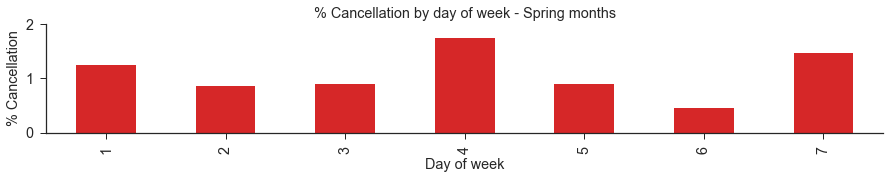

In [762]:
plot_canrate_by_temp_cat(df[df.Month.isin([3,4,5])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Spring months", [0, 2], 6)

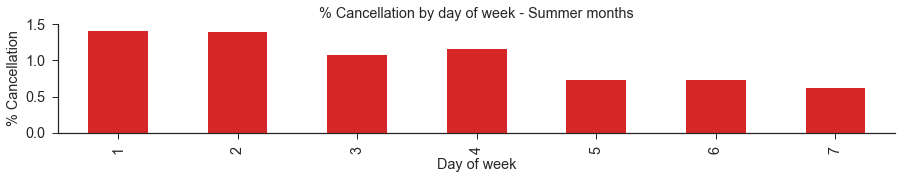

In [763]:
plot_canrate_by_temp_cat(df[df.Month.isin([6,7,8])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Summer months", [0, 1.5], 6)

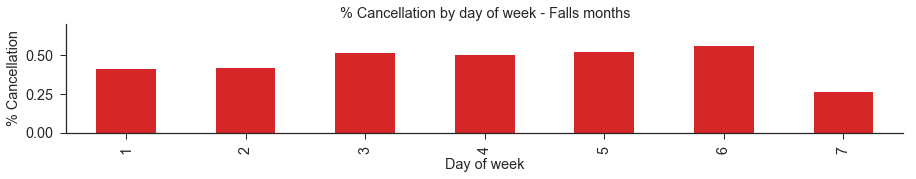

In [764]:
plot_canrate_by_temp_cat(df[df.Month.isin([9,10,11])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Falls months", [0, 0.7], 6)

Actually, there are differences in trends from season to season. In spring months, highest cancellation rate is observed on Thursday. In summer months, there is almost a monotonic decay in cancellation rate from Monday to Sunday. The Falls months' cancellation rate distribution is pretty uniform, except a bit lower rate on Sunday.

Clearly, the day of week alone is not telling the whole story. This variable in cambination with "season" or more accurately with "Month" tells much more details. This shows an interesting interaction between two calander variables. The trend for the whole data is similar to that for the winter months because the cancellation rates are highest and much higher than the rates in other months. 


It is also possible that there are interactions between the day of week and weather condition. What happens to the weekly trend for cancellation rate when the weather condition is, say "Rain" at origin airport?

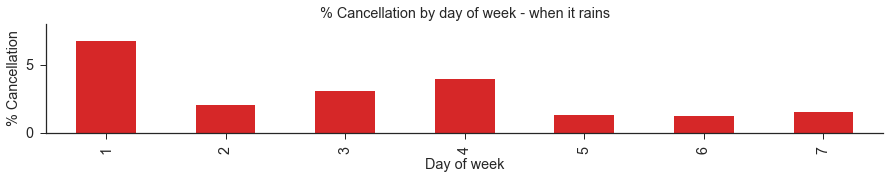

In [765]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Rain"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - when it rains", [0, 8], 6)

Monday is worst when it rains. How about when the sky is clear?

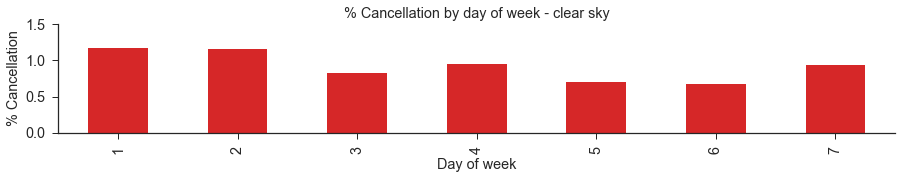

In [766]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Clear"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - clear sky", [0, 1.5], 6)

For clear sky, the rates are pretty small and the distribution is close to being uniform. How about "Heavy Snow"?

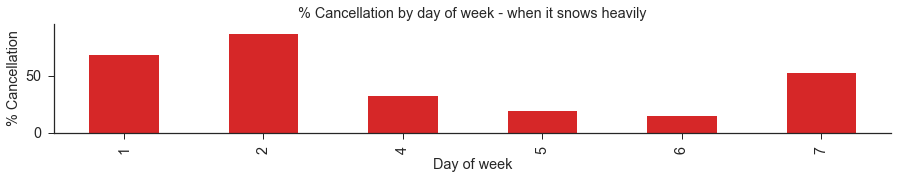

In [767]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Heavy Snow"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - when it snows heavily", [0, 95], 6)

Tuesday is worst when it snows heavily. Monday and Sunday see high cancellation rates too. This conclusion may not be very general because it may be due to coincidence that heavy snow happended only on Monday and Tuesday in 2015 winter months.

We can similarly explore the day of week at destination airport too, since there are flights during which the date chamges.


#### DayOfWeek_Dest

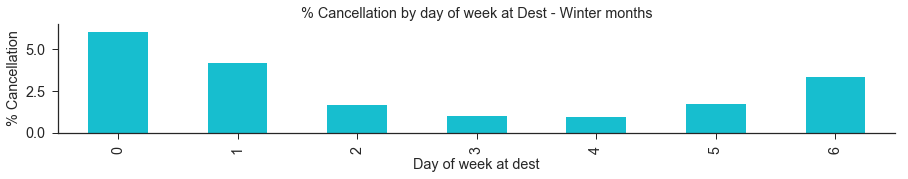

In [768]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([12,1,2])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Winter months", [0, 6.5], 18)

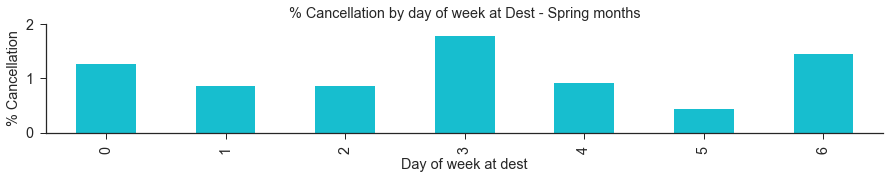

In [769]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([3,4,5])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Spring months", [0, 2], 18)

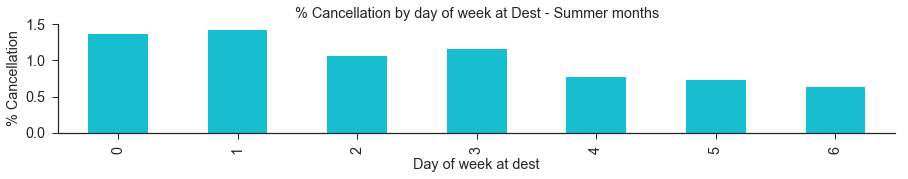

In [770]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([6,7,8])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Summer months", [0, 1.5], 18)

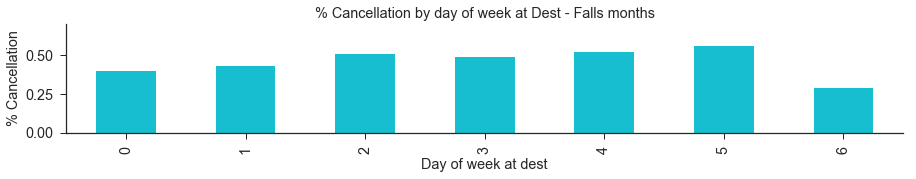

In [771]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([9,10,11])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Falls months", [0, 0.7], 18)

Okay, so there is no difference in patters if we look at the origin airport or destination airport's day of week.

There is another temporal variable "CRSDepHr", which might be a good predictor for cancellation rates. This variable contains the scheduled departure hour of the day.

#### CRSDepHr

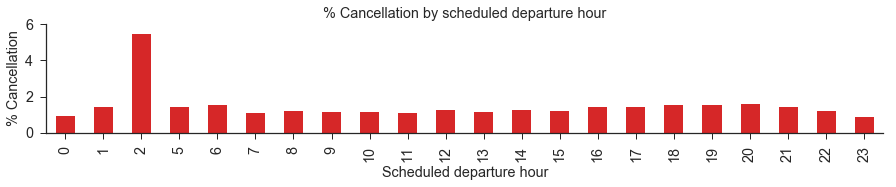

In [772]:
plot_canrate_by_temp_cat(df, "CRSDepHr", "Scheduled departure hour", "% Cancellation", "% Cancellation by scheduled departure hour", [0, 6], 6)

For all hours, the cancellation rates are below 2%. However, something heppens between 2 - 3 AM in the morning when the cancellation rate is more than 5%. Do we see this same trend for CRSArrHr (scheduled arrival hour)?

#### CRSArrHr

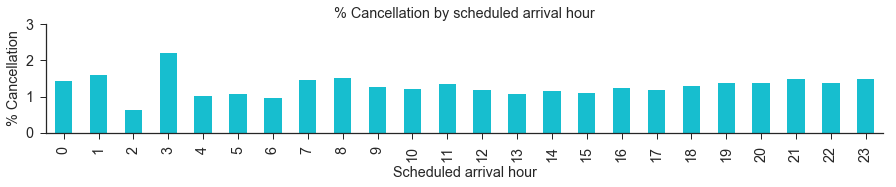

In [773]:
plot_canrate_by_temp_cat(df, "CRSArrHr", "Scheduled arrival hour", "% Cancellation", "% Cancellation by scheduled arrival hour", [0, 3], 18)

We do not see any big peak for cancellation rate in CRSArrHr. However, the highest cancellation rate is seen for 3 - 4 AM which is one hour after the 2 - 3 AM time range (for which we saw a big peak in CRSDepHr). This makes sense because the arrival time will always be after the departure time.

Let us try to understand why do we see a big spike in cancellation rate at 2 - 3 AM CRSDepHr? Since the cancellation rate is a ratio of the number of flights cancelled to total number of flights for a given scenario, it is highly likely that the number of flights is pretty small for 2 - 3 AM CRSDepHr flight scenario. Lets check the distribution of number of flghits at all CRSDepHr.

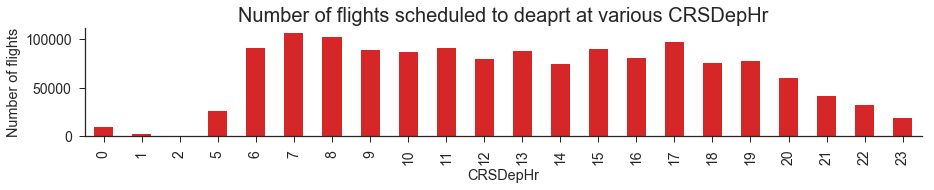

In [774]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
df.groupby("CRSDepHr")["CRSDepHr"].count().plot(kind="bar", zorder=0, color=tableau20[6])
plt.ylabel("Number of flights")
plt.title("Number of flights scheduled to deaprt at various CRSDepHr", size=20)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)

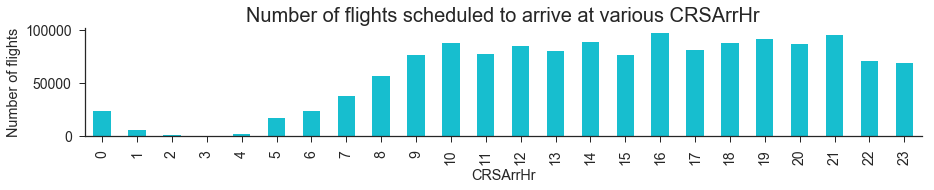

In [775]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
df.groupby("CRSArrHr")["CRSArrHr"].count().plot(kind="bar", zorder=0, color=tableau20[18])
plt.ylabel("Number of flights")
plt.title("Number of flights scheduled to arrive at various CRSArrHr", size=20)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)

It is indeed the truth. How many flights were scheduled to depart between 2 - 3 AM in year 2015 at top 20 airports?

In [776]:
print("Out of",sum(df.CRSDepHr == 2), "flights", sum((df.CRSDepHr == 2) & (df.Cancelled == 1)), "were canceled")

Out of 110 flights 6 were canceled


There are some other times (3 - 5 AM) when not even a single flight was scheduled to depart. 


Overall, we think both CRSDepHr and CRSArrHr could be good predictors for predictiong cancellation rates.

So far we have looked calander variables. Lets now explore some spatial variables like airport location, state, type etc.

#### Origin

In [816]:
def plot_canrate_by_cat1(df, by, xlab, ylab, title, sort, width, height, tbl, ylim):
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    can_rate = (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count())
    
    can_rate_sorted = can_rate.sort_values(ascending=False)
    
    colors = [tableau20[tbl]]
    
    if sort:
        ax = can_rate_sorted.plot(kind='bar',color=colors, zorder=0)
    else:
        ax = can_rate.plot(kind='bar',color=colors, zorder=0)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title, size=20)
    plt.ylim(ylim)
    hide_topright(ax)
    plt.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=60)
    #ax.invert_yaxis()
    return(fig)

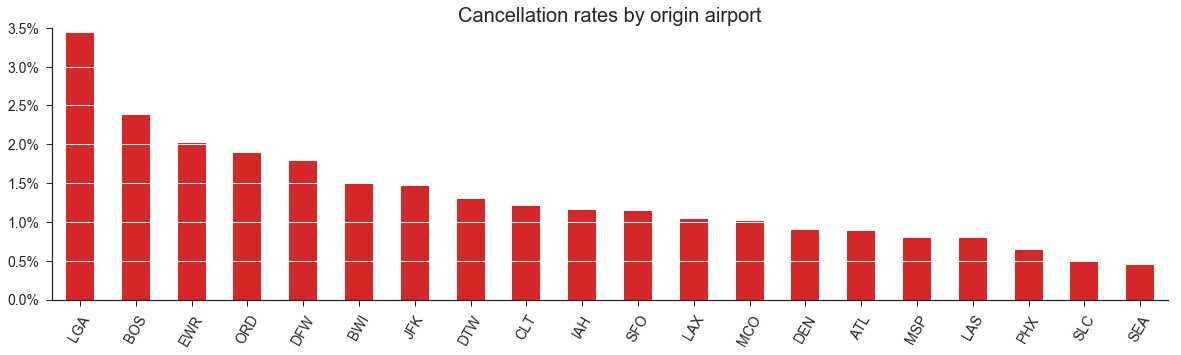

In [817]:
plot_canrate_by_cat1(df, "Origin", "", "", "Cancellation rates by origin airport", sort=True, width=20, 
                     height=5, tbl=6, ylim=[0, 3.5]);

In case the reader is not familiar with these airport codes, following is the mapping between codes and names:

ATL - Hartsfield Jackson Atlanta International

BOS - General Edward Lawrence Logan International	Boston

BWI - Baltimore/Washington International Thurgood Marshall	Baltimore

CLT - Charlotte Douglas International	Charlotte

DEN - Denver International	Denver

DFW - Dallas Fort Worth International	Dallas-Fort Worth

DTW - Detroit Metropolitan Wayne County	Detroit	

EWR - Newark Liberty International	Newark

IAH - George Bush Intercontinental Houston	Houston

JFK - John F Kennedy International	New York

LAS - McCarran International	Las Vegas

LAX - Los Angeles International	Los Angeles	

LGA - La Guardia	New York

MCO - Orlando International	Orlando	

MSP - Minneapolis-St Paul International/Wold-Chamberlain	Minneapolis	

ORD - Chicago O’Hare International	

PHX - Phoenix Sky Harbor International	Phoenix

SEA - Seattle Tacoma International	Seattle

SFO - San Francisco International	San Francisco	

SLC - Salt Lake City International	Salt Lake City	

The flights departing from LGA have the highest cancellation rate whereas the flights departing from SEA have lowest rate. Lets also have a look at the number of flights departed from top 20 airports for those same top 20 airports in 2015.

In [841]:
print(df.groupby("Origin")["Origin"].count().sort_values(ascending=False))

Origin
LAX    115702
ORD    107907
ATL    102920
SFO     92604
DEN     88940
DFW     83631
LAS     76392
PHX     76282
BOS     69629
SEA     63398
MCO     61110
CLT     60636
IAH     57566
MSP     55672
EWR     54406
JFK     54403
DTW     54399
LGA     53578
SLC     50472
BWI     37661
Name: Origin, dtype: int64


It is possible that the above trend will be different at different time of the year. Lets check out the pattern for all four major seasons.

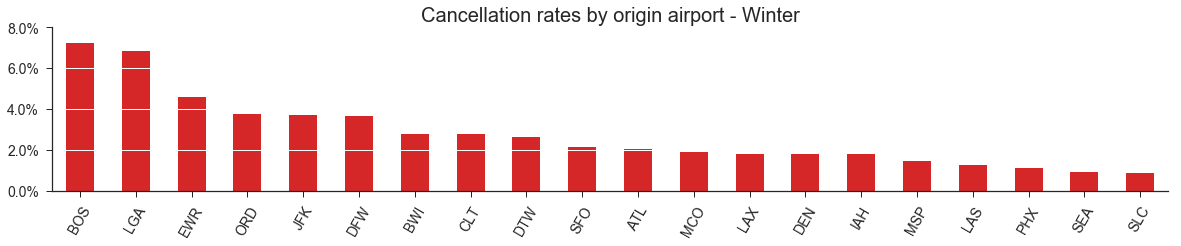

In [905]:
plot_canrate_by_cat1(df[df.Month.isin([12,1,2])], "Origin", "", "", "Cancellation rates by origin airport - Winter", sort=True, width=20, height=3, tbl=6, ylim=[0, 8]);

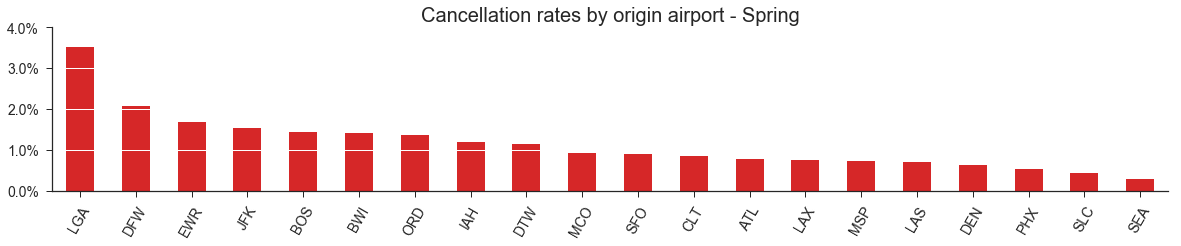

In [907]:
plot_canrate_by_cat1(df[df.Month.isin([3,4,5])], "Origin", "", "", "Cancellation rates by origin airport - Spring", sort=True, width=20, height=3, tbl=6, ylim=[0, 4]);

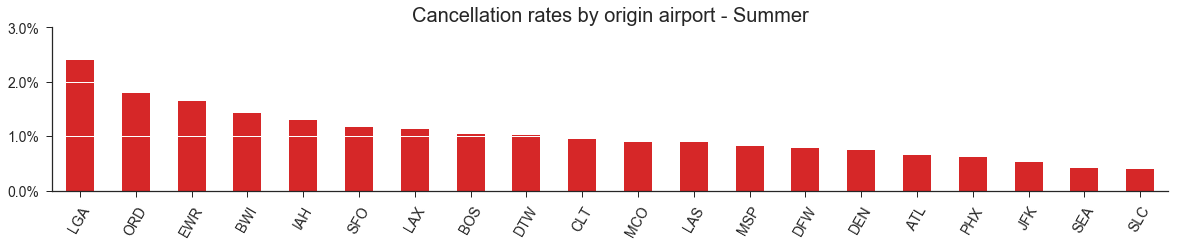

In [908]:
plot_canrate_by_cat1(df[df.Month.isin([6,7,8])], "Origin", "", "", "Cancellation rates by origin airport - Summer", sort=True, width=20, height=3, tbl=6, ylim=[0, 3]);

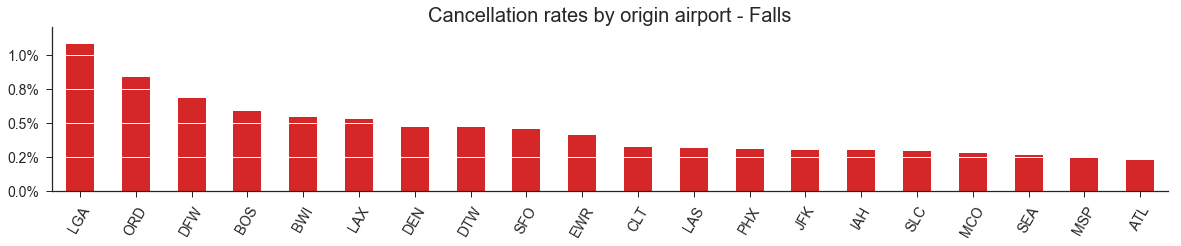

In [911]:
plot_canrate_by_cat1(df[df.Month.isin([9,10,11])], "Origin", "", "", "Cancellation rates by origin airport - Falls", sort=True, width=20, height=3, tbl=6, ylim=[0, 1.2]);

Usually, LaGuardia is the worst thoroughout the year, and Seattle and Salt Lake City are the best ones. Clearly, there is interaction between the season (or months) and the origin airport. 

How about the destination location?

#### Dest

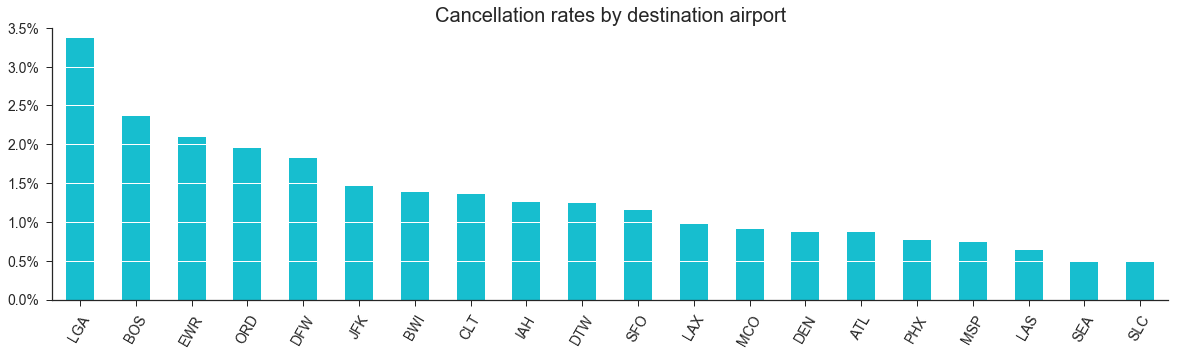

In [818]:
plot_canrate_by_cat1(df, "Dest", "", "", "Cancellation rates by destination airport", sort=True, width=20, 
                     height=5, tbl=18, ylim=[0, 3.5]);

The top 2 and the botton 2 remains the same whether we are looking at origin or destination airport. We can also look at origin and destination states too. We have considered 1 airport from each state, except for NY, CA and TX where we considered 2 airports. So, the bar chart by state will look very similar to above plots. Lets visualize them.

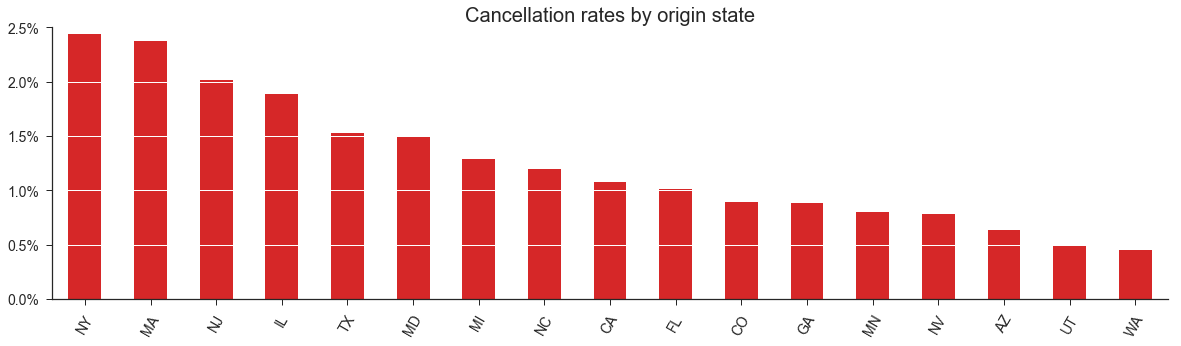

In [820]:
plot_canrate_by_cat1(df, "OriginState", "", "", "Cancellation rates by origin state", sort=True, width=20, 
                     height=5, tbl=6, ylim=[0, 2.5]);

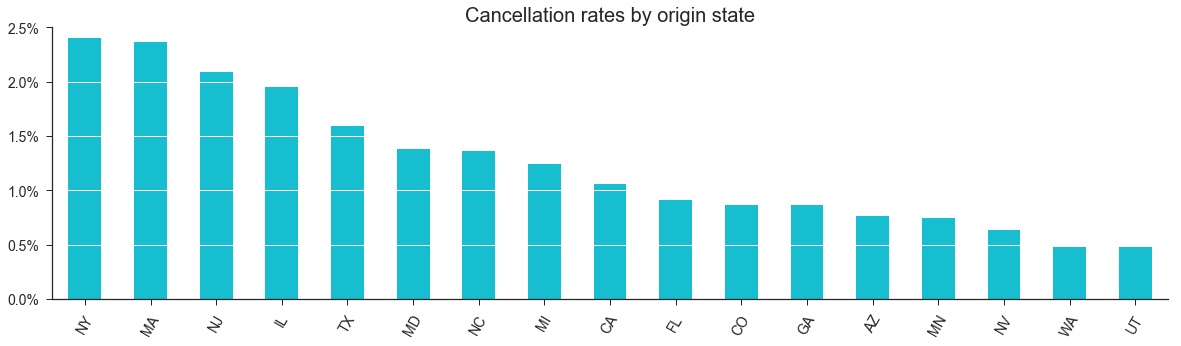

In [821]:
plot_canrate_by_cat1(df, "DestState", "", "", "Cancellation rates by origin state", sort=True, width=20, 
                     height=5, tbl=18, ylim=[0, 2.5]);

We observe pretty much the same pattern. Therefore, rather than state, we should keep Origin and Dest in the model. For that, we will first need to create dummy columns for Origin and Dest indicators.


***<font color='red' size=5>TODO: Create dummy columns for Origin and Dest</font>***

Lets us now look at how different airlines hae different cancellation rates.


#### Carrier

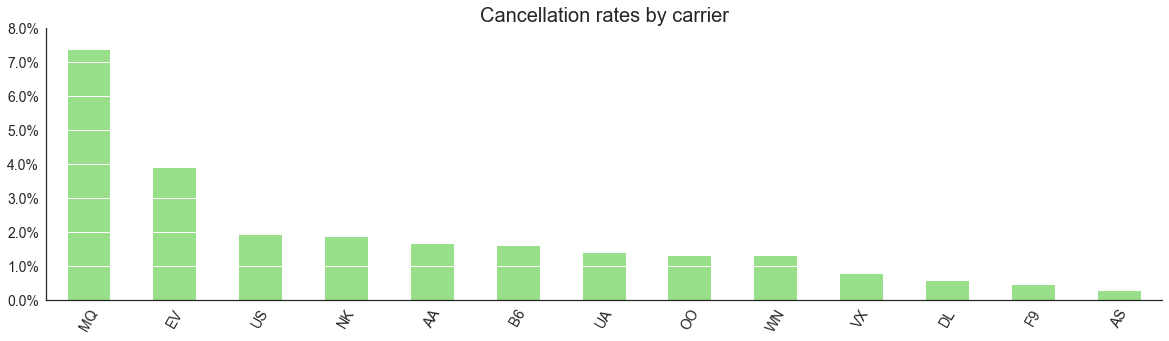

In [1333]:
plot_canrate_by_cat1(df, "Carrier", "", "", "Cancellation rates by carrier", sort=True, width=20, 
                     height=5, tbl=5, ylim=[0, 8]);

Lets first get the name of airlines:

MQ - Envoy Air

EV - ExpressJet Airlines

US - US Airways

NK - Spirit Airlines

AA - American Airlines

B6 - Jetblue Airways 

UA - United Airlines

OO - SkyWest Airlines

WN - Southwest Airlines

VX - Virgin America

DL - Delta Air Lines

F9 - Frontier Airlines

AS - Alaska Airlines

The highest cancellation rate is seen for the Envoy Air, and lowest is seen for the Alaska Airlines. Again, these numbers are the ratios. We should also look at the actual number of flights by each airlines. 

In [843]:
print(df.groupby("Carrier")["Carrier"].count().sort_values(ascending=False))

Carrier
DL    321739
AA    274074
UA    264495
WN    150733
US     74160
B6     68356
OO     64365
NK     50208
AS     45678
VX     37471
F9     35045
EV     19180
MQ     11804
Name: Carrier, dtype: int64


Cncellation rates are high for both Envoy Air and ExpressJet Airlines but the actual number of flights are lowest for these two carriers. If we look at Delta Air Lines, it has low cancellation rate with highest number of flights. So, DL performs the best amongst its competetors, in terms of cncellation rates. 


Also, DL's network is distributed nationwide. Lets see how many airports does the DL flight depart from? 

In [845]:
len(df.Origin[df.Carrier == "DL"].unique())

20

From all airports in the dataset! How about MQ?

In [846]:
len(df.Origin[df.Carrier == "MQ"].unique())

11

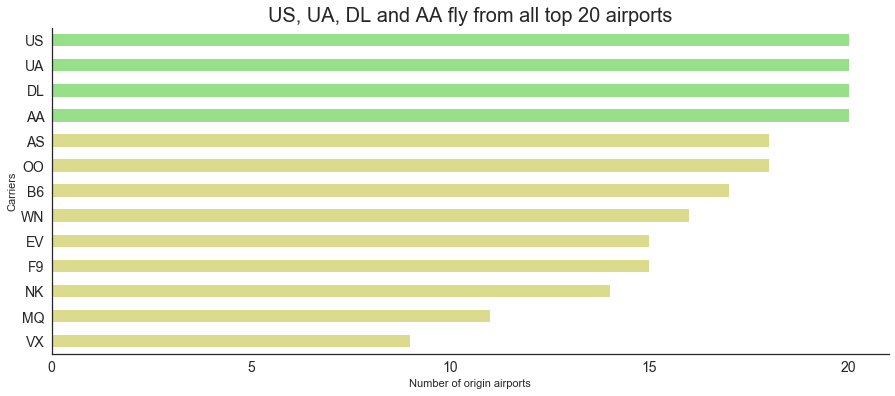

In [1334]:
#fig = plt.subplots(1, 1, figsize=(15, 5))
total = len(df.Carrier.unique())
bottomn = 4
topn = total - bottomn
colors = [tableau20[17]]*topn
colors = colors + [tableau20[5]]*bottomn
ax = pd.DataFrame([{"Carrier": cr, "Origin airports": len(df.Origin[df.Carrier == cr].unique())} 
              for cr in list(df.Carrier.unique())]).sort_values("Origin airports").plot("Carrier", 
                                                                                        "Origin airports",
                                                                                       kind="barh", zorder=0,
                                                                                       color=colors, legend=None)
plt.xlabel("Number of origin airports")
plt.ylabel("Carriers")
plt.title("US, UA, DL and AA fly from all top 20 airports", size=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks([0, 5, 10, 15, 20])
hide_topright(ax)

So, airlines with the highest cancellation rates are the ones that do not cover the whole US, they are type of regional airlines. Lets create a dictionary for the airlines and their types. We would then be able to see if the cancellation rates really depend onthe type of the airlines. We can get the types from [this link](https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States).

MQ - Regional

EV - Regional

US - Mainline (note that US airways was ceased to operate in October 2015)

NK - Mainline

AA - Mainline

B6 - Mainline 

UA - Mainline

OO - Regional

WN - Mainline

VX - Mainline

DL - Mainline

F9 - Mainline

AS - Mainline

In [886]:
airline_type = {"MQ": "Regional", "EV": "Regional", "US": "Mainline", "NK": "Mainline", "AA": "Mainline",
               "B6": "Mainline", "UA": "Mainline", "OO": "Regional", "WN": "Mainline", "VX": "Mainline",
               "DL": "Mainline", "F9": "Mainline", "AS": "Mainline"}

In [889]:
df["AirlineType"] = df.Carrier.map(airline_type)

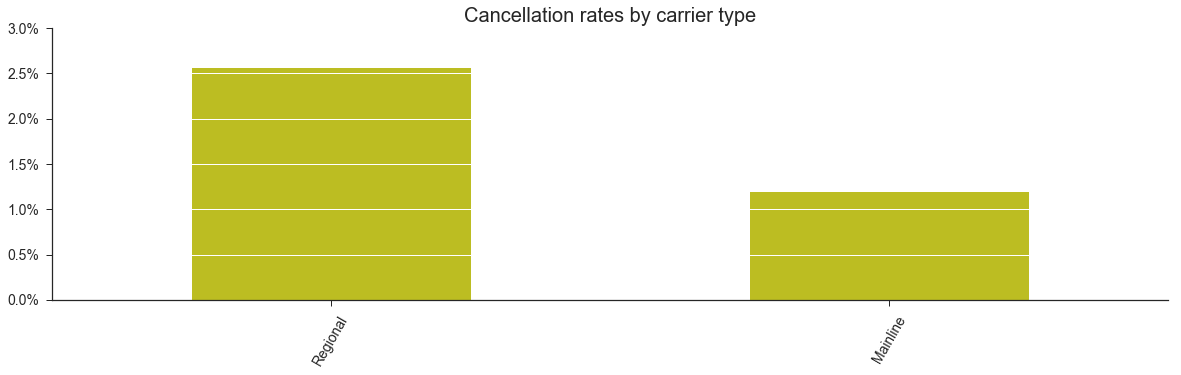

In [898]:
plot_canrate_by_cat1(df, "AirlineType", "", "", "Cancellation rates by carrier type", sort=True, width=20, 
                     height=5, tbl=16, ylim=[0, 3]);

Cancellation rate for regional carriers is almost twice compared with mainline carriers.

Type and name of airlines, and name of airport definitely affects the cancellation rate. Lets now see if the "Distance" of the flight has any influence on cancellation rates.

#### Distance

How does the distribution of Distance look like?

(0, 3000)

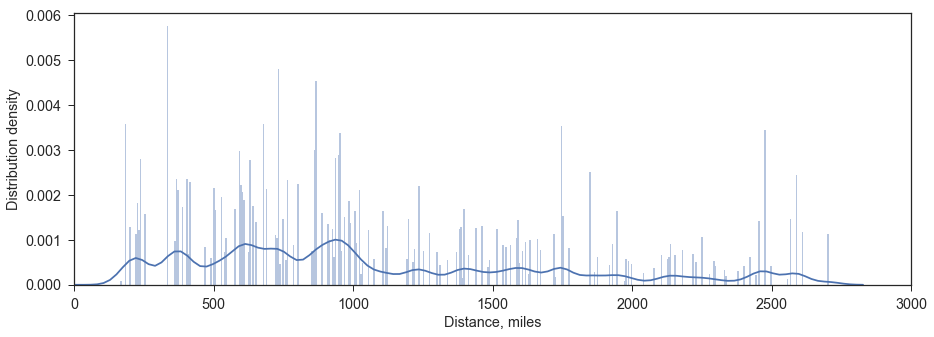

In [1043]:
sns.distplot(df.Distance, norm_hist=False, kde = True, bins=500)
plt.xlabel("Distance, miles")
plt.ylabel("Distribution density")
plt.xlim([0, 3000])

In [916]:
df.Distance.describe()

count    1.417308e+06
mean     1.084718e+03
std      6.595657e+02
min      2.100000e+01
25%      5.990000e+02
50%      9.300000e+02
75%      1.535000e+03
max      2.704000e+03
Name: Distance, dtype: float64

The distribution is not normal and is highly skewed on the right side. There are flights with distance of as short as 21 miles and also as long as 2700 miles!

Lets now plot the cancellation rate as a function of the distance.

In [1195]:
def create_canrate_by_contvar_df(contvar, df):
    # This function is used to create a data frame containing two columns:
        #1. Given continuous variable
        #2. Cancellation rate (in %)
    # contvar: Continuous variable
    # df: original data frame from which to extract the small resultant data frame
    # return: small resultant data frame containing two columns
    dfd = pd.DataFrame({contvar: 
                        df.groupby(contvar)[contvar].head(1).reset_index().drop(["index"], axis=1),
                        "CanRate": 
                        100*df.groupby(contvar)["Cancelled"].sum() / df.groupby(contvar)["Cancelled"].count().get_values()})
    return(dfd.drop(contvar, axis=1).reset_index())

In [1348]:
dfd = create_canrate_by_contvar_df("Distance", df)

In [1351]:
def plot_canrate_by_contvar(contvar, dft, xlab, ylab, xlim, ylim, xlog, tbl, width, height):
    # This function plots the cancellation rate vs the given continuous variable
    # contvar: Continuous variable
    # dft: resultant data frame obtained by running create_canrate_by_contvar_df()
    # return: fig
    fig, ax = plt.subplots(figsize=(width,height))
    ax.scatter(dft[[0]], dft[[1]], color=tableau20[tbl], s=80, alpha=0.8)
    ax.set_xlabel(xlab, size=20)
    ax.set_ylabel(ylab, size=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    if xlog:
        ax.set_xscale('log')
    else:
        pass
    hide_topright(ax)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    return(fig)

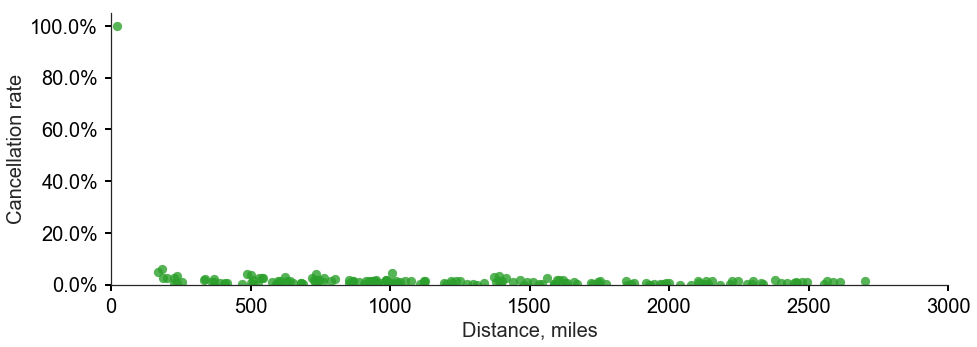

In [1352]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Distance, miles", ylab="Cancellation rate", 
                        xlim=[0, 3000], ylim=[0, 105], xlog=False, tbl=4, width=15, height=5);

Note that there is a data point for Distance = 21 miles for which the cancellation rate was 100%. In order to see the clear trend for all other data points, we will not plot the point for 21 miles. 

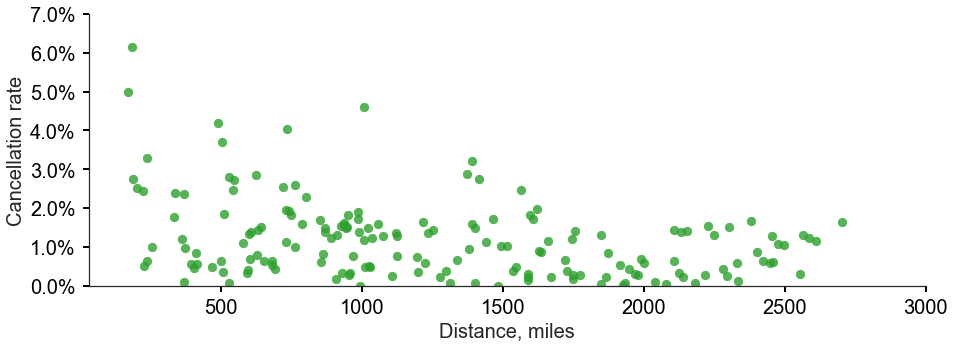

In [1353]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Distance, miles", ylab="Cancellation rate", 
                        xlim=[30, 3000], ylim=[0, 7], xlog=False, tbl=4, width=15, height=5);

We can see that the cancellation rates are higher for short distance flgihts and low for long distance flights. We should keep in mind that the number of flights having very short and very long distances are much lower compared with the number of flights with around 1000 miles (refer to the density plot above). 

Lets now perform a quick hypothesis test to confirm a relationship between cancellation rate and distance. We can use Pearson's r to test the relationship but before that we need to make sure that both variables are normally distributed.

In [1354]:
stats.normaltest(dfd.Distance)

NormaltestResult(statistic=28.870488838628198, pvalue=5.3808762445409858e-07)

In [1355]:
stats.normaltest(dfd.CanRate)

NormaltestResult(statistic=375.06672198592594, pvalue=3.5916676911074039e-82)

Both variables are not normally distributed, so we cannot use Pearson's R. Lets rather calculate Spearman's R and associated p-value.

In [1356]:
stats.spearmanr(dfd.Distance, dfd.CanRate)

SpearmanrResult(correlation=-0.33578295179126383, pvalue=6.2915950296143086e-06)

This test shows that there is a weak negative correlation with correlation coefficient of -0.336, and this number is statistically significant. We can also try with setting the x axis a logscale and plot the scatter plot, and then calculate Spearman's r.

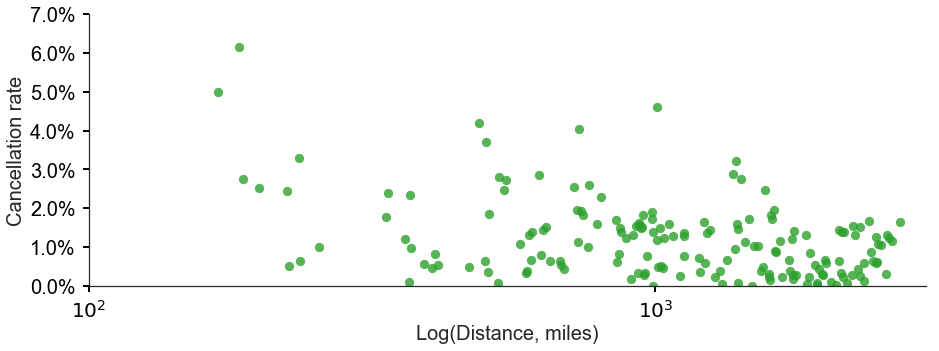

In [1357]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Log(Distance, miles)", ylab="Cancellation rate", 
                        xlim=[100, 3000], ylim=[0, 7], xlog=True, tbl=4, width=15, height=5);

In [1358]:
stats.spearmanr(np.log(dfd.Distance), dfd.CanRate)

SpearmanrResult(correlation=-0.33578295179126383, pvalue=6.2915950296143086e-06)

The plot with log scale looks better (closer to linear), however, the correlation coefficients are exactly the same.

So, we can confirm a weak relationship between the two variables. In other words, the likelihhod of cancellation is higher for short distance flights, and vice versa.

We have many more columns to explore. The remaining columns are either weather related fields or flight history related fields. Lets first understand the influence of historical performance on cancellation rates.

### Historical Performances

We have calculated the historical performances for 3 periods: (i) 10 days, (ii) 20 days, and (iii) 30 days. For example, for 10 days, we look at the flight delay summary, flight cancellations, number of flights etc., for last 10 days of the flight in question. There are 9 columns for each period.

#### Nflight_10

This is the number of flights in last 10 days for a given unique flight. Note that the unique flight is defined based on a unique carrier, unique origin-destination pair, and a unique scheduled departure time window. The minimum value of Nflights_10 can be 0. If the value of Nflights_10 is 0, then it means that there was no such similar flight in last 10 days. We will call such flights as "temporary" flight later. But for the time being, lets just start exploring Nflights_10. 

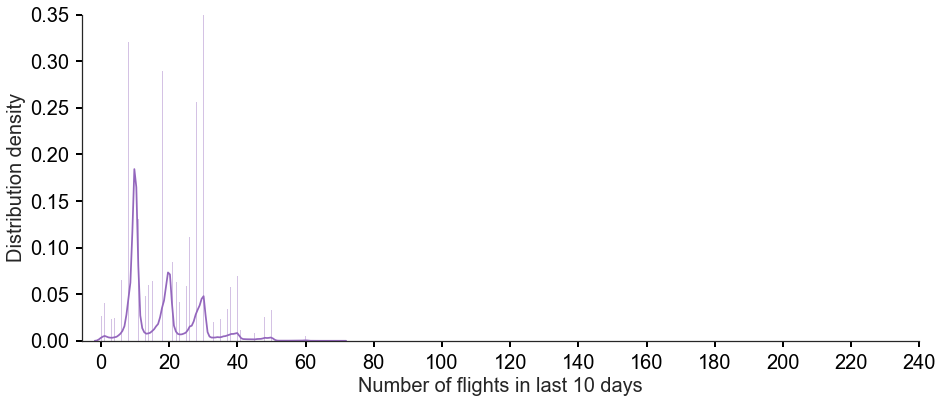

In [1360]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Nflights_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of flights in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.35])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [1361]:
df.Nflights_10.describe()

count    1.417308e+06
mean     1.768743e+01
std      9.977437e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.600000e+01
75%      2.500000e+01
max      7.000000e+01
Name: Nflights_10, dtype: float64

We can see a trimodal distribution for Nflights_10. Since we define a time window of 120 minutes in feature engineering stage, we can have multiple unique flights in a single day. This is why we have the value of Nflighs_10 to be as large as 70. The peaks in the distribution are at about 10, 20 and 30. This might mean that we have 1, 2, and 3 flights (of the same type) in a 120 mins window in last 10 days.


Lets now consider the Nflights_10 as a continuous variable, and plot cancellation rate against it.

First we create a data frame containing two columns: Nflights_10 and cancellation rate (in %). Basically, we want pick all the flights for which Nflights_10 is, say, 5. And then we count the number of such flights, and also the number of cancelled flights. The ratio will then give us the cancellation rate for Nflights_10 = 5.

In [1488]:
dfd10 = create_canrate_by_contvar_df("Nflights_10", df)

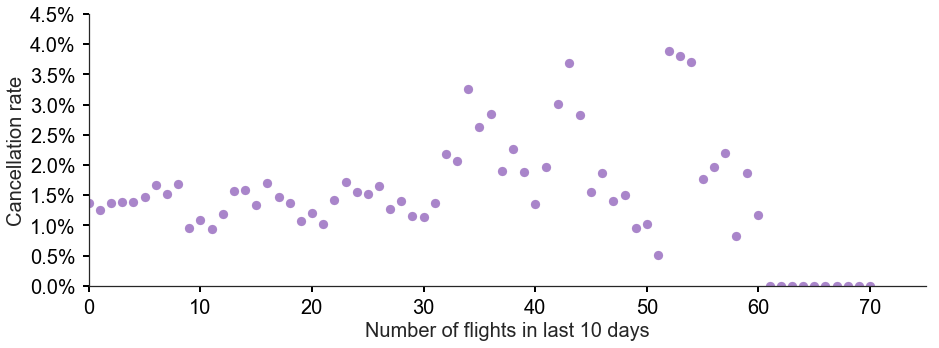

In [1489]:
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 75], ylim=[0, 4.5], xlog=False, tbl=8, width=15, height=5);

We observe an oscillation behaviour with dips at multiples of 10. This directly corresponds to the peaks in the histogram above. To understand this better, lets pick one peak, say 10, which indicates that we are tracking flights (of the same type) that are scheduled only once a day. We have the most data points when the number of flights in last 10 days are 10, and least cancellation rate for 10 too. For less data points (or less distribution density), the cancellation rates are higher. A similar pattern is observed for other peaks too. However, after 30 the fluctuations are higher. For more than 60 number of flights in last 10 days, the cancellation rates are absolutely 0. Overall, we do not observe any linear or monotonic trend here, but there are periodic trends. Can we see a more general periodic trend? To see that, lets explore Nflghits_20 and Nflights_30, i.e. the number of flights in last 20 and 30 days, respectively. We can visualize all of them together.

#### Nflights_10, Nflights_20, Nflights_30

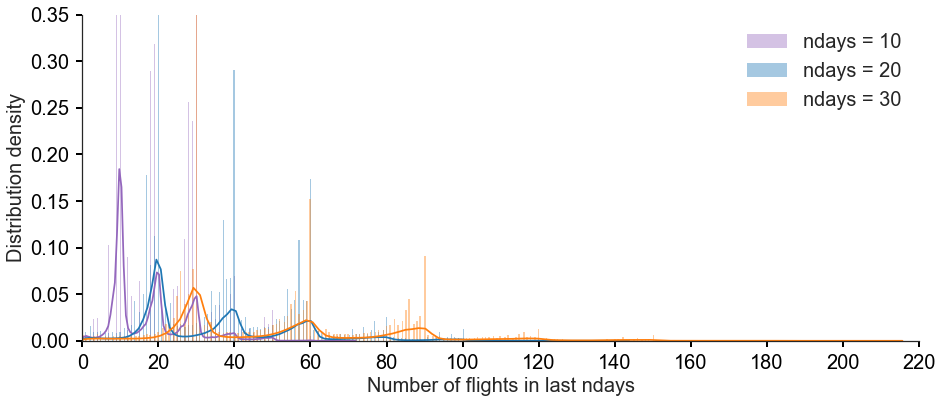

In [1490]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Nflights_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.Nflights_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.Nflights_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Number of flights in last ndays", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.35])
plt.xlim([0,220])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

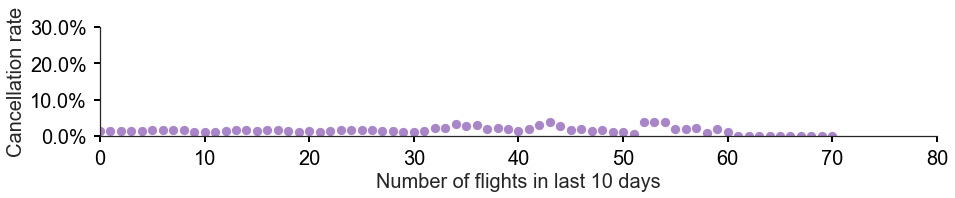

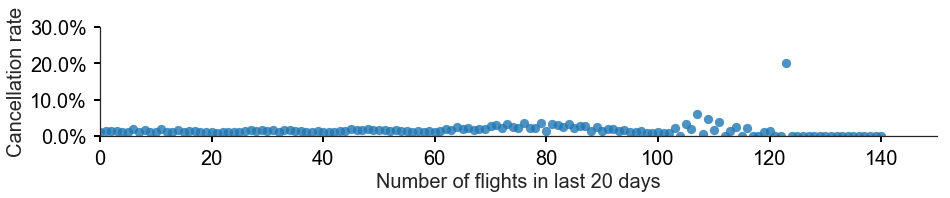

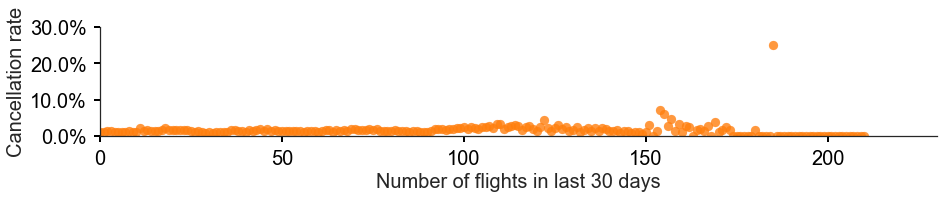

In [1491]:
dfd20 = create_canrate_by_contvar_df("Nflights_20", df)
dfd30 = create_canrate_by_contvar_df("Nflights_30", df)
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 80], ylim=[0, 30], xlog=False, tbl=8, width=15, height=2);
plot_canrate_by_contvar(contvar="Nflights_20", dft=dfd20, xlab="Number of flights in last 20 days", 
                        ylab="Cancellation rate", xlim=[0, 150], ylim=[0, 30], xlog=False, tbl=0, width=15, height=2);
plot_canrate_by_contvar(contvar="Nflights_30", dft=dfd30, xlab="Number of flights in last 30 days", 
                        ylab="Cancellation rate", xlim=[0, 230], ylim=[0, 30], xlog=False, tbl=2, width=15, height=2);

In order to see the trends clearly, lets ignore two data points for which the cancellation rates are higher than 8%.

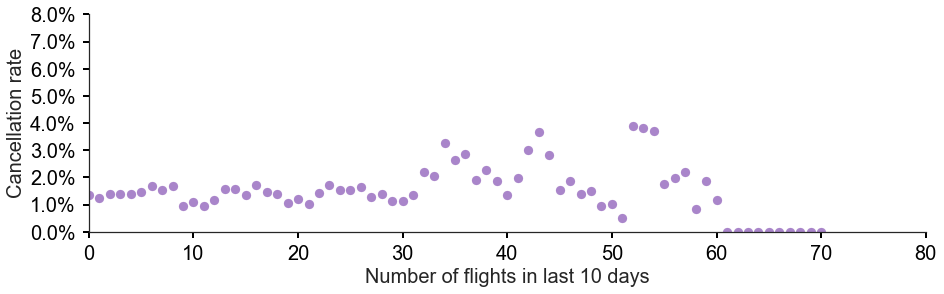

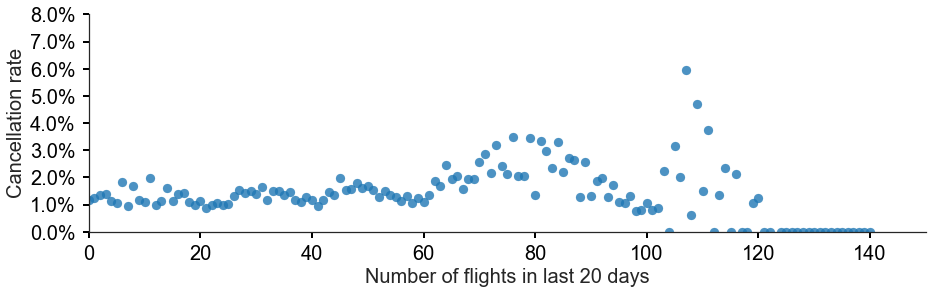

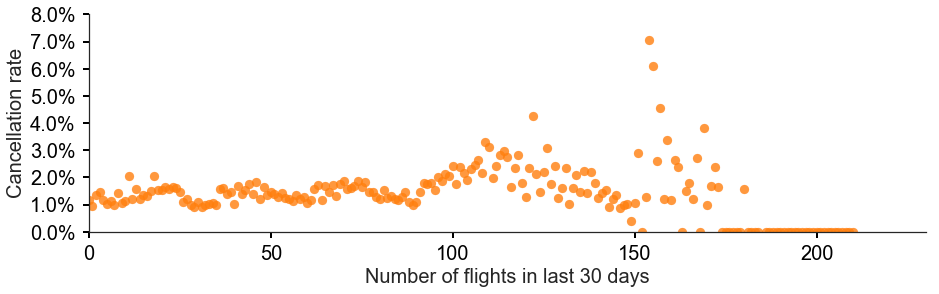

In [1367]:
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 80], ylim=[0, 8], xlog=False, tbl=8, width=15, height=4);
plot_canrate_by_contvar(contvar="Nflights_20", dft=dfd20, xlab="Number of flights in last 20 days", 
                        ylab="Cancellation rate", xlim=[0, 150], ylim=[0, 8], xlog=False, tbl=0, width=15, height=4);
plot_canrate_by_contvar(contvar="Nflights_30", dft=dfd30, xlab="Number of flights in last 30 days", 
                        ylab="Cancellation rate", xlim=[0, 230], ylim=[0, 8], xlog=False, tbl=2, width=15, height=4);

A very similar trend is seen for 20 and 30 days history too. We see peaks in distribution at multiple of 20 and troughs in cancellation rates at same points when we look at 20 days history data. After 60, the fluctuation becomes larger for 20 days data. For 30 days history, the peaks in distribution are seen at multiple of 20 and troughs in cancellation rates are seen at same points. The fluctuations become larger after 90 for 30 days history case.


So, whether the history is for 10, 20 or 30 days, we observe a general periodic trend in cancellation rates with minimum at multiple of ndays (where ndays is the number of days we are looking the history for).

Lets now explore if the number of cancellations in last ndays has any effect on the likelhood of cancellation for today (or for the flight in question).

#### Ncan_10

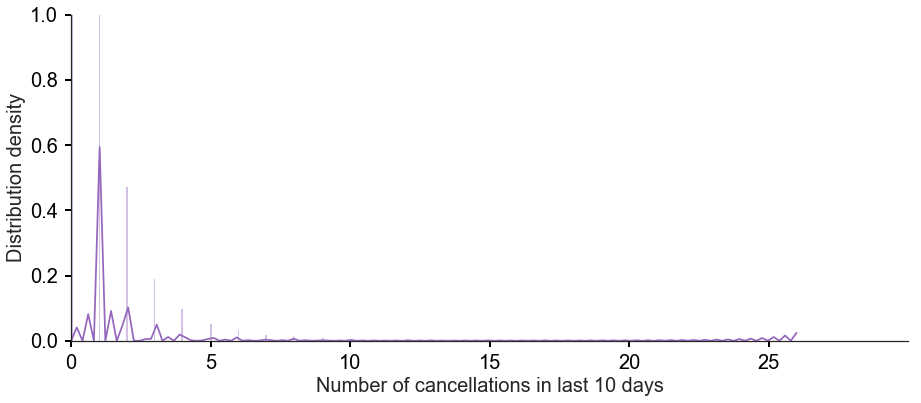

In [1385]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ncan_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of cancellations in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20, 25], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [1369]:
df.Ncan_10.describe()

count    1.417308e+06
mean     2.376738e-01
std      8.473823e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.600000e+01
Name: Ncan_10, dtype: float64

The majority of flights have only 1 cancelled flight in last 10 days. There are flights (or may be a flight) of the same type with 26 cancellations in last 10 days. We can plot similar type of scatter plots that we did for Nflights_ndays.

In [1494]:
dfd10 = create_canrate_by_contvar_df("Ncan_10", df)

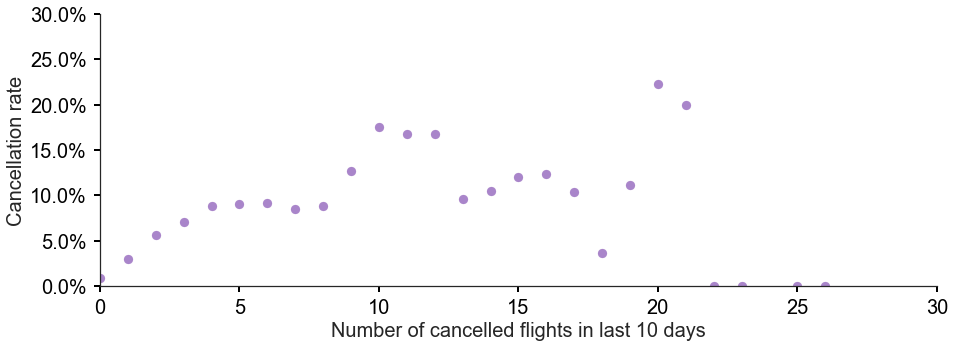

In [1495]:
plot_canrate_by_contvar(contvar="Ncan_10", dft=dfd10, xlab="Number of cancelled flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 30], ylim=[0, 30], xlog=False, tbl=8, width=15, height=5);

Lets try to understand this plot by picking one data point, say x = 2, y $\sim$ 6%. For this point, we get all the flights (or rows) for which the 10 days hostory tells us that 2 flights got cancelled in last 10 days. Out of all those selected flights, we then count the number of flights that got cancelled. The ratio of these the number of cancelled flights to the total number of selected flights is what we report on the y axis, in this case it is about 6%. We see a parabolic trend between the two variables with maximum cancellation rate occuring when the number of cancelled flights are about 10. 


Lets visualize the distributions for all ndays together.

#### Ncan_10, Ncan_20, Ncan_30

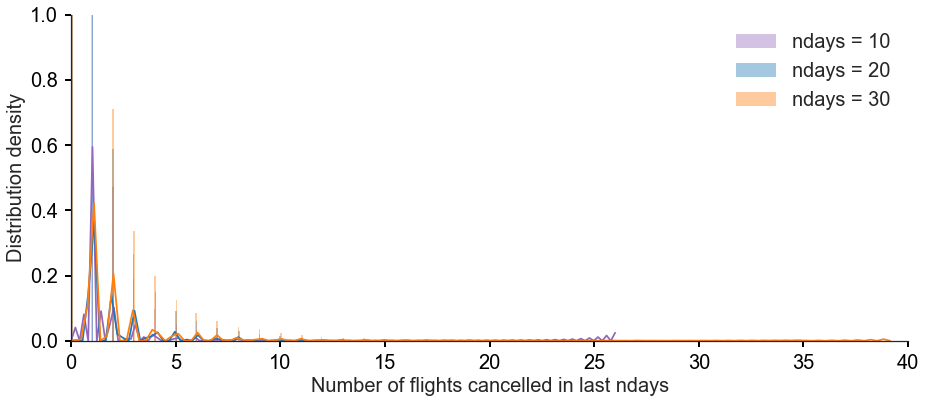

In [1496]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ncan_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.Ncan_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.Ncan_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Number of flights cancelled in last ndays", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,40])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

How about the effect of the number of cancelled flights in last ndays on cancellation rates for all three values of ndays?

In [1497]:
dfd20 = create_canrate_by_contvar_df("Ncan_20", df)
dfd30 = create_canrate_by_contvar_df("Ncan_30", df)

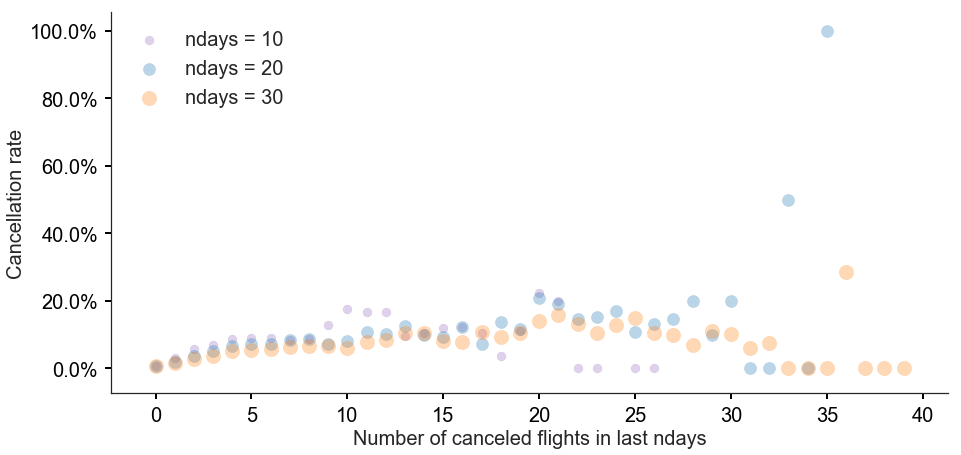

In [1498]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Number of canceled flights in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20, loc=2)

For all ndays, we observe a parabolic pattern with maximum in cancellation occuring at different values of the number of cancellations in last ndays. There also appears to be some outliers in all three cases, usually at higher values of the number of cancellations in last ndays. 

#### Ndiv_10

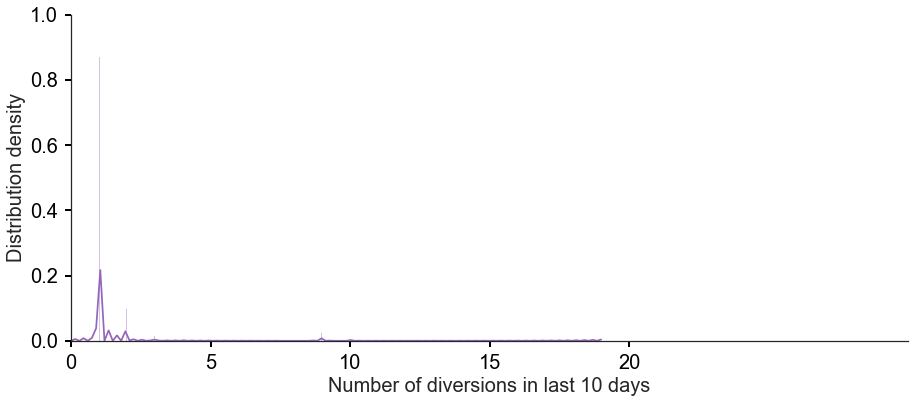

In [1499]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ndiv_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of diversions in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [1500]:
df.Ndiv_10.describe()

count    1.417308e+06
mean     5.423310e-02
std      4.039853e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.900000e+01
Name: Ndiv_10, dtype: float64

The majority of flights have only 1 diverted flight in last 10 days. There are flights (or may be a flight) of the same type with 19 diversions in last 10 days. We can plot similar type of scatter plots that we did for Ncan_ndays.

In [1501]:
dfd10 = create_canrate_by_contvar_df("Ndiv_10", df)

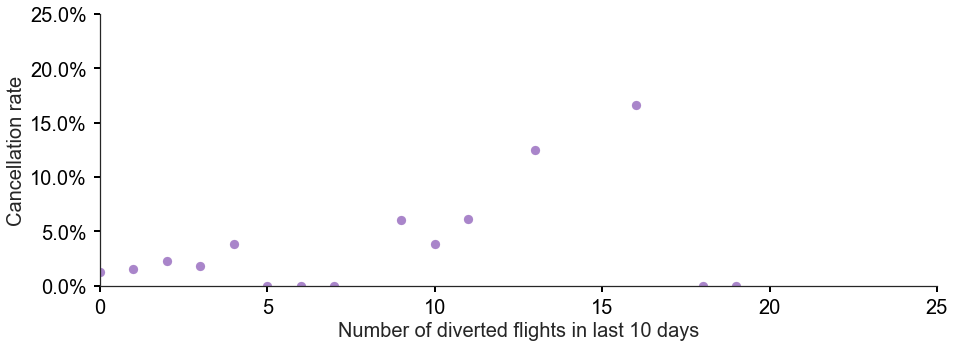

In [1502]:
plot_canrate_by_contvar(contvar="Ndiv_10", dft=dfd10, xlab="Number of diverted flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 25], ylim=[0, 25], xlog=False, tbl=8, width=15, height=5);

Similar to Nflights_ndays and Ncan_ndays, lets look at all ndays history together.

#### Ndiv_10, Ndiv_20, Ndiv_30

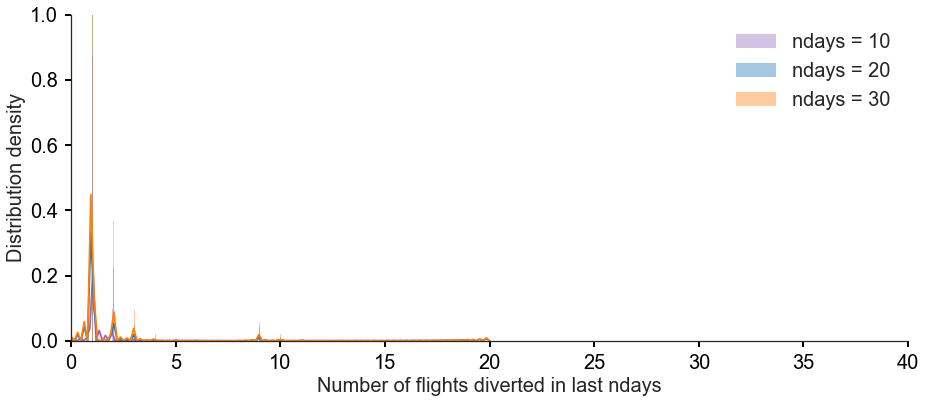

In [1503]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ndiv_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.Ndiv_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.Ndiv_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Number of flights diverted in last ndays", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,40])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [1504]:
dfd20 = create_canrate_by_contvar_df("Ndiv_20", df)
dfd30 = create_canrate_by_contvar_df("Ndiv_30", df)

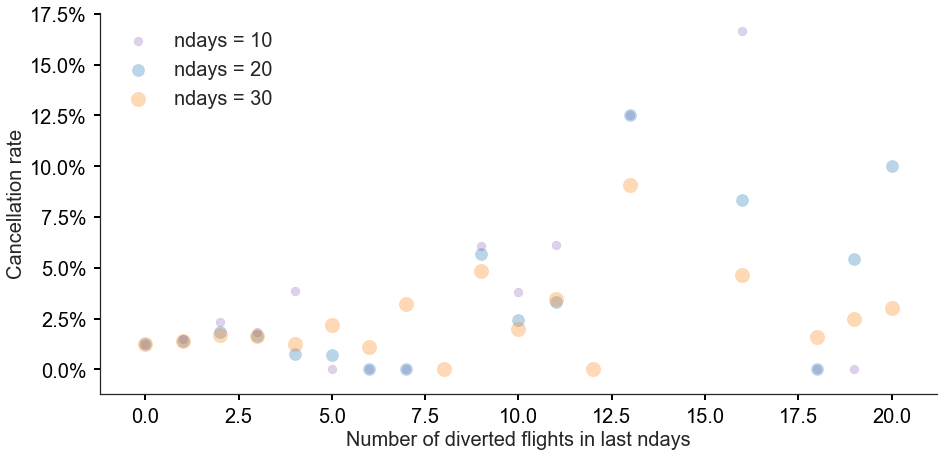

In [1505]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Number of diverted flights in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20, loc=2)

Usually, the canellation likelihood fora flight is higher when the number of diversions of that flight in the last ndays are higher.


Having looked at various numbers, lets now look at some more intersting numbers related with historical performances. Sometimes, we come across a flight for which we do not find any history in ndays. We call such flights as temporary flights. The term "temporary" could be different for different ndays. For example, a flight can be temporary if looked at 10 days history but "routine" if looked at 30 days history. This is why we have three such fields: (i) TempFlight_10, (ii) TempFlight_20, and (iii) TempFlight_30 that have 0 and 1 indicating if the flight was temporary or not. Lets explore these indicator columns now.


#### TempFlight_10, TempFlight_20, TempFlight_30 

How many flights were temporary (based on ndays history)?

Is it the case that a temporary flight has high or low probability of cancellation?

Lets find answers to these questions.

In [1506]:
print(100*sum(df.TempFlight_10 == 1)/len(df), "% of the total flights were temporary based on 10 days history")
print(100*sum(df.TempFlight_20 == 1)/len(df), "% of the total flights were temporary based on 20 days history")
print(100*sum(df.TempFlight_30 == 1)/len(df), "% of the total flights were temporary based on 30 days history")

0.0927109703748 % of the total flights were temporary based on 10 days history
0.0778235923314 % of the total flights were temporary based on 20 days history
0.0716851947495 % of the total flights were temporary based on 30 days history


The fractions of temporary flights are very small. However, do these very small number of temporary flights have high chance of getting cancelled? Lets find out.

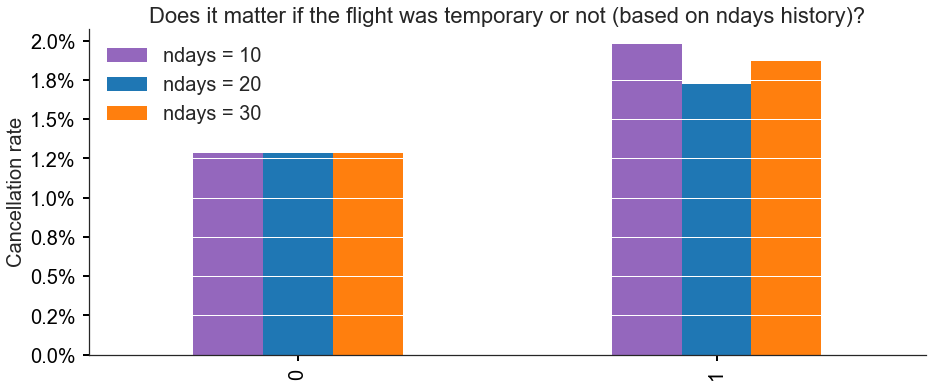

In [1507]:
ax = pd.concat([create_canrate_by_contvar_df("TempFlight_10", df), 
           create_canrate_by_contvar_df("TempFlight_20", df),
           create_canrate_by_contvar_df("TempFlight_30", df)], 
               axis=1).iloc[:, [1,3,5]].plot(kind="bar",
                                             color=[tableau20[8], tableau20[0], tableau20[2]], zorder=0)

plt.xlabel("", fontsize=20)
plt.ylabel("Cancellation rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Does it matter if the flight was temporary or not (based on ndays history)?", fontsize=22)
plt.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)
ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

Here, 1 indicates the temporary flight. For any ndays, whether the flight was temporary or not, the cancellation rates are pretty small. However, the cancellation rates are little bit higher for temporary flights as compared with non-temporary (or routine) flights.

For some flights, all the similar flights in the last ndays got cancelled. If all the similar flights in last ndays got cancelled, is the current flight in question going to be cancelled as well? We track this information about the all flight cancellation in in last ndays by the following columns:


#### AllCanceled_10, AllCanceled_20, AllCanceled_30


These columns have value 1 if all the flights in last ndays got canceled, otherwise 0. The temporary flights are not included in these indicator columns. In other words, these columns have value 0 for temporary flights.

In [1508]:
print(100*sum(df.AllCanceled_10 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 10 days")
print(100*sum(df.AllCanceled_20 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 20 days")
print(100*sum(df.AllCanceled_30 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 30 days")

0.291820832169 % of the total flights had 100% cancellation history based on last 10 days
0.226203478708 % of the total flights had 100% cancellation history based on last 20 days
0.188244192511 % of the total flights had 100% cancellation history based on last 30 days


The fractions of the flights with 100 cancellation history in ndays are very small. However, do these very small number of such flights have high chance of getting cancelled? Lets find out.

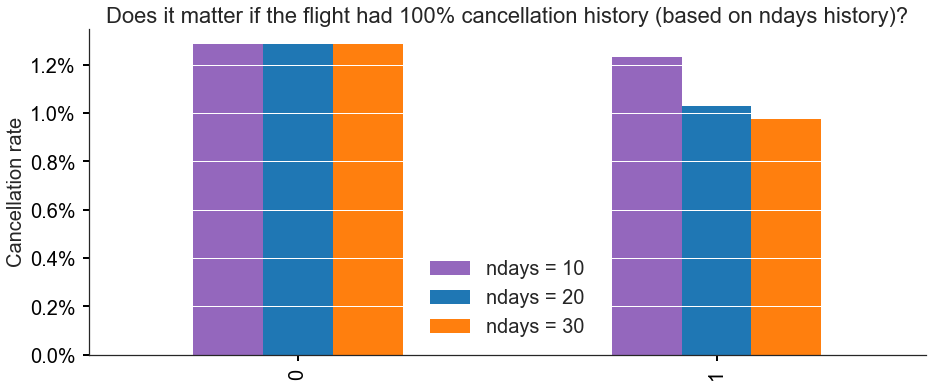

In [1509]:
ax = pd.concat([create_canrate_by_contvar_df("AllCanceled_10", df), 
           create_canrate_by_contvar_df("AllCanceled_20", df),
           create_canrate_by_contvar_df("AllCanceled_30", df)], 
               axis=1).iloc[:, [1,3,5]].plot(kind="bar",
                                             color=[tableau20[8], tableau20[0], tableau20[2]], zorder=0)

plt.xlabel("", fontsize=20)
plt.ylabel("Cancellation rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Does it matter if the flight had 100% cancellation history (based on ndays history)?", fontsize=22)
plt.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)
ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

Looking at 10 days history, it does not matter to cancellation rate of the current flight if all the flights in last 10 days got cancelled or not. However, when we look at 20 and 30 days history, then the flights have relatively low cancellation rates if all the similar flights got canceled in the last 20, 30 days.

Similar to AllCanceled_ndays, we also have AllDiverted_ndays. These columns indicate if, for a given flight, all the flights in last ndays got diverted. Lets explore these columns now.


#### AllDiverted_10, AllDiverted_20, AllDiverted_30


These columns have value 1 if all the flights in last ndays got diverted, otherwise 0. The "all canceled history" flights and temporary flights are not included in these indicator columns. In other words, these columns have value 0 for temporary flights and for flights that had 100% cancellation history.

In [1510]:
print(100*sum(df.AllDiverted_10 == 1)/len(df), "% of the total flights had 100% diversion history based on last 10 days")
print(100*sum(df.AllDiverted_20 == 1)/len(df), "% of the total flights had 100% diversion history based on last 20 days")
print(100*sum(df.AllDiverted_30 == 1)/len(df), "% of the total flights had 100% diversion history based on last 30 days")

0.00148168217494 % of the total flights had 100% diversion history based on last 10 days
0.000423337764269 % of the total flights had 100% diversion history based on last 20 days
0.000211668882134 % of the total flights had 100% diversion history based on last 30 days


These numbers are really very small. Even then, lets see if it gives any interesting pattern.

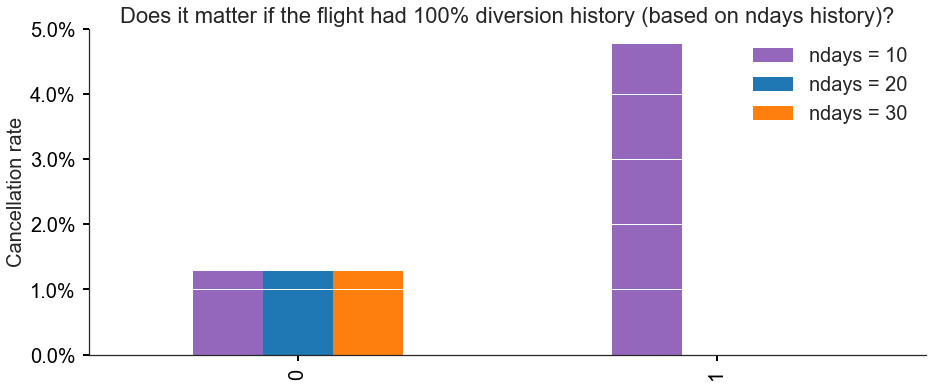

In [1511]:
ax = pd.concat([create_canrate_by_contvar_df("AllDiverted_10", df), 
           create_canrate_by_contvar_df("AllDiverted_20", df),
           create_canrate_by_contvar_df("AllDiverted_30", df)], 
               axis=1).iloc[:, [1,3,5]].plot(kind="bar",
                                             color=[tableau20[8], tableau20[0], tableau20[2]], zorder=0)

plt.xlabel("", fontsize=20)
plt.ylabel("Cancellation rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Does it matter if the flight had 100% diversion history (based on ndays history)?", fontsize=22)
plt.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)
ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

If we look at 10 days history, it is 5 times more likelihood for the cancellation of the flight that had 100% diversion history. For 20 and 30 days history, none of the flights, that had 100% diversion, got canceled.

Along the same lines, we also have AllCanDiv_ndays columns. These fields indicate if, for a given flight, all the flights in last ndays either cancelled OR diverted.


#### AllCanDiv_10, AllCanDiv_20, AllCanDiv_30

These columns have value 1 if all the flights in last ndays either got canceled or diverted, otherwise 0. The temporary flights, and the flights for which there was 100% cancellation or diversion history, are not included in these indicator columns. In other words, these columns have value 0 for temporary flights, all cancelled history flights and all diverted history flights.

In [1512]:
print(100*sum(df.AllCanDiv_10 == 1)/len(df), "% of the total flights had 100% of the flights in last 10 days that either got canceled or diverted")
print(100*sum(df.AllCanDiv_20 == 1)/len(df), "% of the total flights had 100% of the flights in last 20 days that either got canceled or diverted")
print(100*sum(df.AllCanDiv_30 == 1)/len(df), "% of the total flights had 100% of the flights in last 30 days that either got canceled or diverted")

0.0 % of the total flights had 100% of the flights in last 10 days that either got canceled or diverted
7.05562940448e-05 % of the total flights had 100% of the flights in last 20 days that either got canceled or diverted
0.0 % of the total flights had 100% of the flights in last 30 days that either got canceled or diverted


The fractions are actually 0 for 10 and 30 days history but very small fraction for 20 days history. 

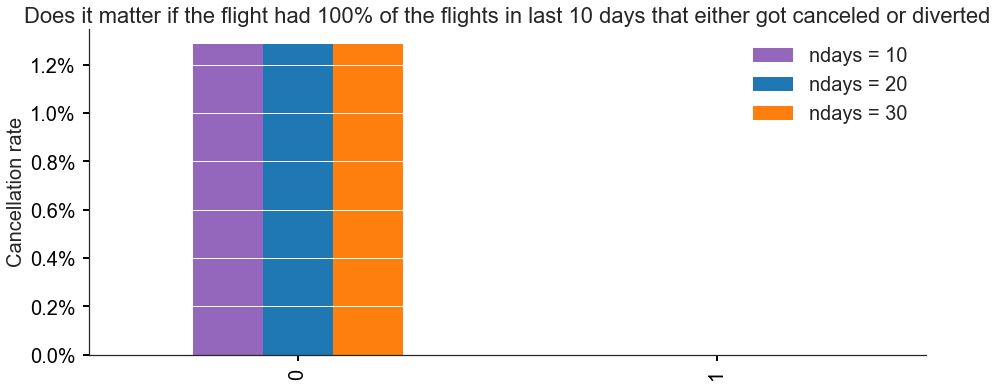

In [1513]:
ax = pd.concat([create_canrate_by_contvar_df("AllCanDiv_10", df), 
           create_canrate_by_contvar_df("AllCanDiv_20", df),
           create_canrate_by_contvar_df("AllCanDiv_30", df)], 
               axis=1).iloc[:, [1,3,5]].plot(kind="bar",
                                             color=[tableau20[8], tableau20[0], tableau20[2]], zorder=0)

plt.xlabel("", fontsize=20)
plt.ylabel("Cancellation rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Does it matter if the flight had 100% of the flights in last 10 days that either got canceled or diverted", fontsize=22)
plt.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)
ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

When a "routine "flight has a history such that all the similar flights in last ndays got either canceled or diverted (but no 100% cancellation and no 100% diversion), then its cancellation rate was 0.


Having looked at numbers of flights in various scenarios, lets focus on some historical statistics such as median, and max values of delays, taxi time etc.

#### DepDelayMedian_10

This is the median value of the departure delays (in minutes) in last 10 days.

In [1514]:
df.DepDelayMedian_10.describe()

count    1.417308e+06
mean     1.714233e+00
std      9.294125e+00
min     -1.800000e+01
25%     -3.000000e+00
50%     -1.000000e+00
75%      3.000000e+00
max      6.770000e+02
Name: DepDelayMedian_10, dtype: float64

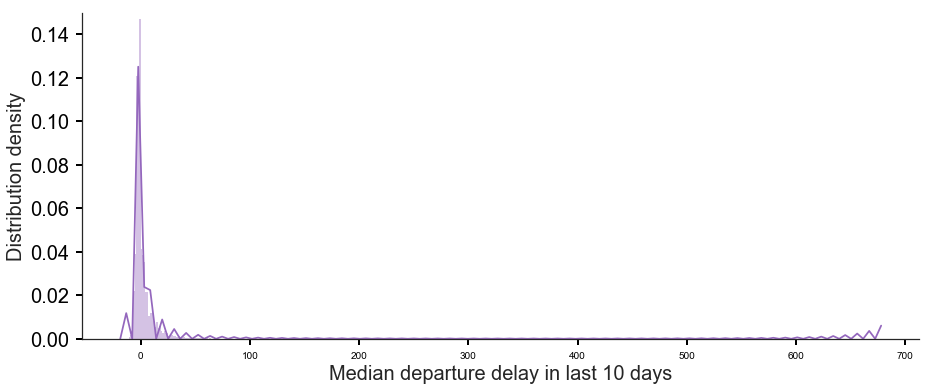

In [1515]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.DepDelayMedian_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Median departure delay in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
#plt.xticks([0, 5, 10, 15, 20], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.15])
#plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

For most of the flights, the median dealy of the similar flights in last 10 days is close to 0. Ther are some flights for which the median delay of similar flights in last 10 days is even greater than 10 hours. However, number of such flights are very small as depicted in the tail of the above distribution. On the other extreme, there are flights that had very good historical performances. The history of these flights tell that there were early departures (on median) in last 10 days, but again the number of such flights were very small.

In [1598]:
dfd10 = create_canrate_by_contvar_df("DepDelayMedian_10", df)

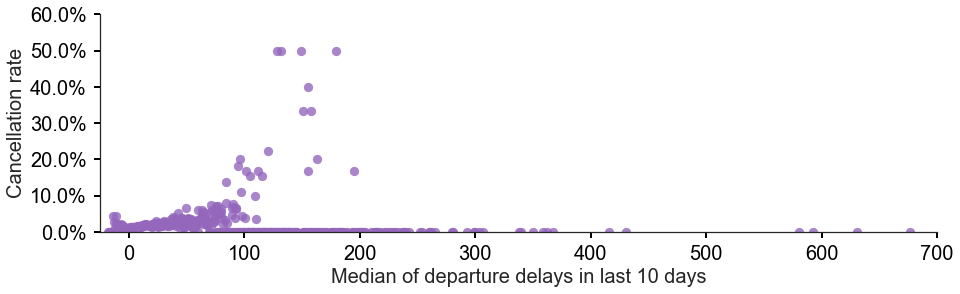

In [1599]:
plot_canrate_by_contvar(contvar="DepDelayMedian_10", dft=dfd10, xlab="Median of departure delays in last 10 days", 
                        ylab="Cancellation rate", xlim=[-25, 700], ylim=[0, 60], xlog=False, tbl=8, width=15, height=4);

Cancellation rates are 0 when the medians of departure delays in last 10 days were greater than 200 minutes. For less than 200 mins, there is a somewhat increasing cancellation rate as a function of median values. Lets visualize these plots for other ndays too.

#### DepDelayMedian_10, DepDelayMedian_20, DepDelayMedian_30

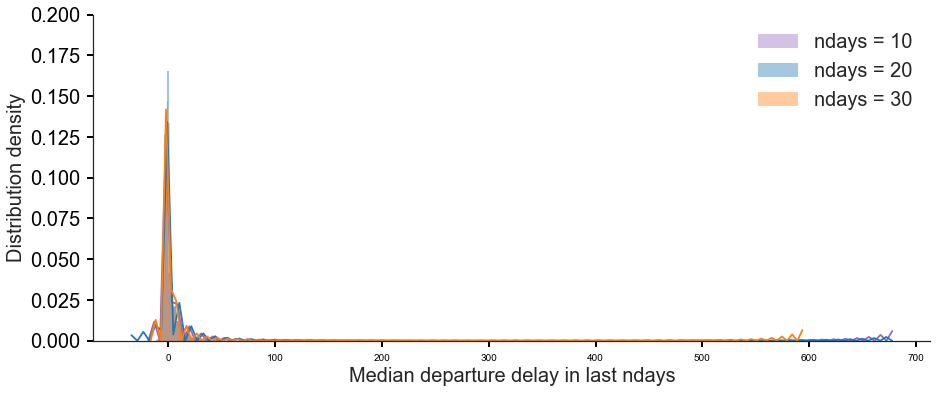

In [1600]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.DepDelayMedian_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.DepDelayMedian_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.DepDelayMedian_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Median departure delay in last ndays", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
#plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.2])
#plt.xlim([0,40])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

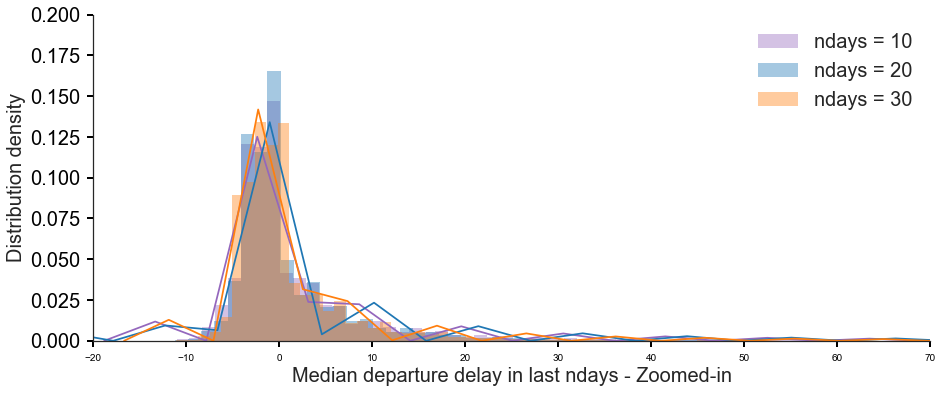

In [1601]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.DepDelayMedian_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.DepDelayMedian_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.DepDelayMedian_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Median departure delay in last ndays - Zoomed-in", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
#plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.2])
plt.xlim([-20,70])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [1602]:
dfd20 = create_canrate_by_contvar_df("DepDelayMedian_20", df)
dfd30 = create_canrate_by_contvar_df("DepDelayMedian_30", df)

We observe similar trends for all ndays cases.

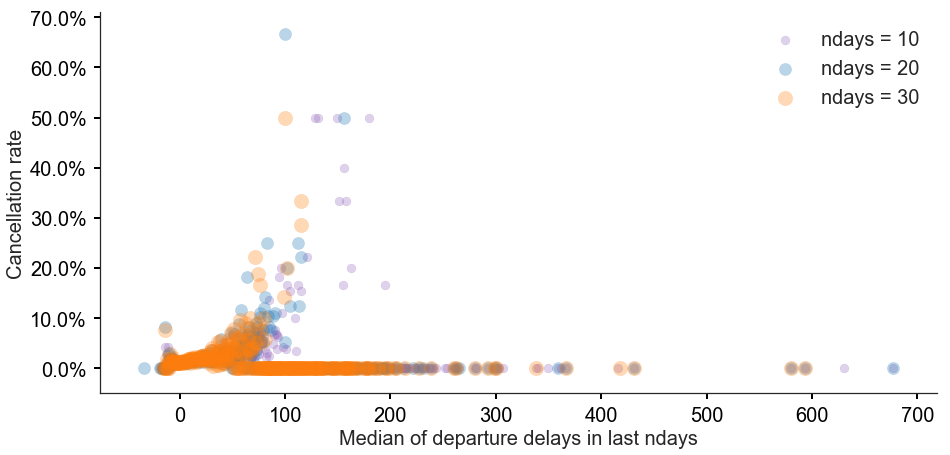

In [1603]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Median of departure delays in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20)

We do not see any clear trend here, except some monotonicity for x < 50. Lets zoom-in the plot above and see if there is any pattern.

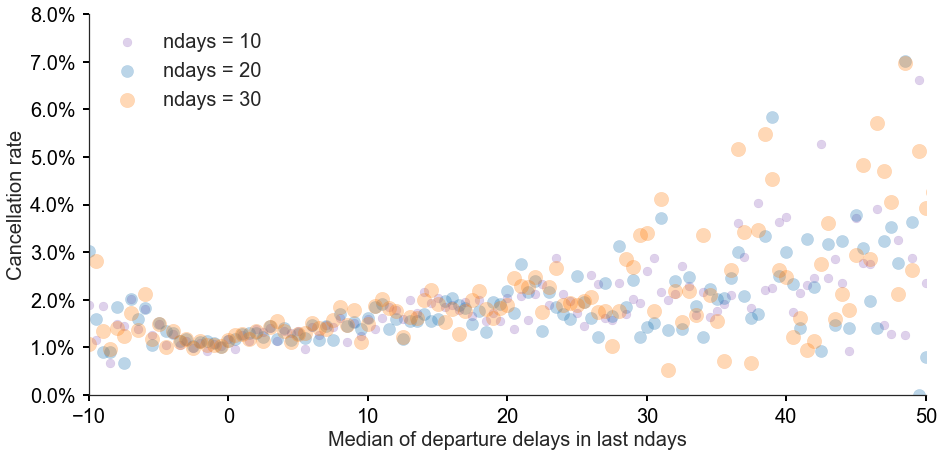

In [1604]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Median of departure delays in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
ax.set_xlim([-10, 50])
ax.set_ylim([0, 8])
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20)

There seems to be some correlation when we zoom-in. Lets test these correlations using Spearman's r. 

In [1605]:
stats.spearmanr(dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 50)][[0]], 
                dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 50)][[1]])

SpearmanrResult(correlation=0.70527702606466325, pvalue=3.4329563386140556e-19)

In [1606]:
stats.spearmanr(dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 50)][[0]], 
                dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 50)][[1]])

SpearmanrResult(correlation=0.60811958431869695, pvalue=2.2183082069693314e-13)

In [1607]:
stats.spearmanr(dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 50)][[0]], 
                dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 50)][[1]])

SpearmanrResult(correlation=0.59843896325320023, pvalue=6.5958379157748512e-13)

There are pretty good correlations that are statistically significant. The range of medians that we picked above covers about 30% of all the data points as shown in the distribution plot.

In [1609]:
print(len(dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 50)])/len(dfd10))
print(len(dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 50)])/len(dfd20))
print(len(dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 50)])/len(dfd30))

0.28743961352657005
0.3269230769230769
0.35522388059701493


Lets now look at the maximum values of departures delays in last n days.

#### DepDelayMax_10, DepDelayMax_20, DepDelayMax_30

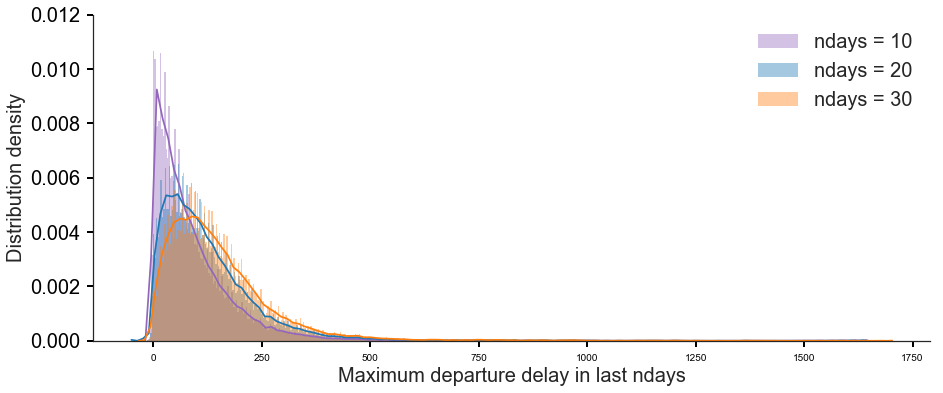

In [1610]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.DepDelayMax_10, norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
ax = sns.distplot(df.DepDelayMax_20, norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
ax = sns.distplot(df.DepDelayMax_30, norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
plt.xlabel("Maximum departure delay in last ndays", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
#plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.012])
#plt.xlim([0,40])
plt.legend(fontsize=20)
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

The distribution of maximum departure times is quite different from the distribution of median values. There are flights for which the similar flights in 30 days had a delay of more than a day! On the other hand, there are flights for which the similar flights in last ndays had early departures too. Lets now see the effect of maximum of departure delays in last ndays on cancellation rate.

In [1611]:
dfd10 = create_canrate_by_contvar_df("DepDelayMax_10", df)
dfd20 = create_canrate_by_contvar_df("DepDelayMax_20", df)
dfd30 = create_canrate_by_contvar_df("DepDelayMax_30", df)

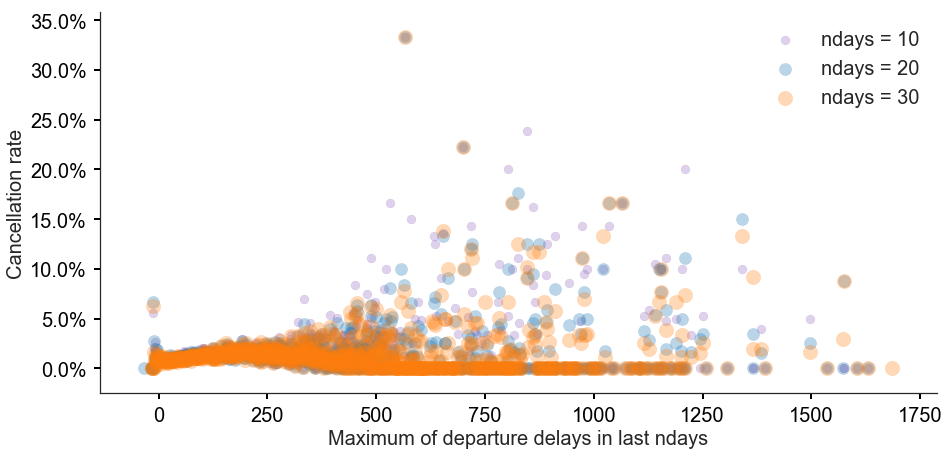

In [1612]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Maximum of departure delays in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
#ax.set_xlim([0,200])
#ax.set_ylim([0,3])
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20)

We do not see any clear trend here, except some monotonicity for x < 250. Lets zoom-in the plot above and see if there is any pattern.

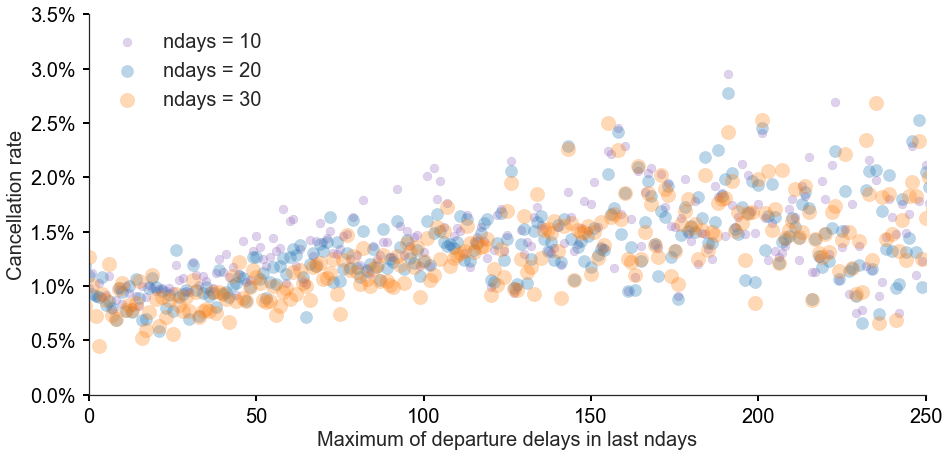

In [1613]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")
ax.set_xlabel("Maximum of departure delays in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
ax.set_xlim([0,250])
ax.set_ylim([0,3.5])
ax.tick_params(direction='out', length=6, width=2, colors='k')
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(fontsize=20, loc=2)

There seems to be some linear behaviour here. Lets calculate the Spearman's r and associated p-values for all ndays cases. 

In [1614]:
stats.spearmanr(dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)][[0]], 
                dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)][[1]])

SpearmanrResult(correlation=0.49973970068786411, pvalue=3.8903570317642343e-17)

In [1615]:
stats.spearmanr(dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)][[0]], 
                dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)][[1]])

SpearmanrResult(correlation=0.58171239797901275, pvalue=6.0465493187200859e-24)

In [1616]:
stats.spearmanr(dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)][[0]], 
                dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)][[1]])

SpearmanrResult(correlation=0.70273688301593473, pvalue=2.168842155951643e-38)

There are pretty good correlations between cancellation rate and maximum values of departure delays in last ndays for all ndays (10, 20, 30) and the correlations are statistically significant. The correlation above is seen for the cases when the maximum of departure delays are between 0 and 250 mins, which covers about 28% of the data points as seen in the distribution plot.

In [1618]:
print(len(dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)])/len(dfd10))
print(len(dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)])/len(dfd20))
print(len(dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)])/len(dfd30))

0.2885283893395133
0.28719723183391005
0.2868663594470046


In [1168]:
df

Year  Quarter  Month  DayofMonth  DayOfWeek Carrier Origin  \
0        2015        1      1           1          4      AA    PHX   
1        2015        1      1           1          4      NK    PHX   
2        2015        1      1           1          4      DL    DEN   
3        2015        1      1           1          4      NK    LAS   
4        2015        1      1           1          4      NK    LAS   
5        2015        1      1           1          4      AA    SFO   
6        2015        1      1           1          4      DL    SEA   
7        2015        1      1           1          4      NK    PHX   
8        2015        1      1           1          4      DL    SFO   
9        2015        1      1           1          4      DL    LAS   
10       2015        1      1           1          4      DL    LAX   
11       2015        1      1           1          4      DL    SLC   
12       2015        1      1           1          4      UA    LAX   
13       2015        1      1           1          4      UA    SFO   
14       2015        1      1           1          4      NK    LAS   
15       2015        1      1           1          4      F9    MSP   
16       2015        1      1           1          4      B6    BOS   
17       2015        1      1           1          4      EV    CLT   
18       2015        1      1           1          4      OO    DFW   
19       2015        1      1           1          4      F9    DFW   
20       2015        1      1           1          4      DL    LAS   
21       2015        1      1           1          4      OO    SLC   
22       2015        1      1           1          4      OO    DEN   
23       2015        1      1           1          4      DL    SLC   
24       2015        1      1           1          4      UA    BOS   
25       2015        1      1           1          4      UA    MSP   
26       2015        1      1           1          4      UA    ORD   
27       2015        1      1           1          4      DL    BOS   
28       2015        1      1           1          4      NK    LAX   
29       2015        1      1           1          4      B6    BOS   
...       ...      ...    ...         ...        ...     ...    ...   
1417278  2015        4     12          31          4      UA    LAX   
1417279  2015        4     12          31          4      DL    SFO   
1417280  2015        4     12          31          4      AA    LAX   
1417281  2015        4     12          31          4      DL    SFO   
1417282  2015        4     12          31          4      B6    PHX   
1417283  2015        4     12          31          4      NK    LAS   
1417284  2015        4     12          31          4      DL    SFO   
1417285  2015        4     12          31          4      F9    LAX   
1417286  2015        4     12          31          4      UA    LAS   
1417287  2015        4     12          31          4      UA    SFO   
1417288  2015        4     12          31          4      NK    LAX   
1417289  2015        4     12          31          4      DL    LAX   
1417290  2015        4     12          31          4      UA    SFO   
1417291  2015        4     12          31          4      F9    LAS   
1417292  2015        4     12          31          4      DL    SEA   
1417293  2015        4     12          31          4      UA    LAX   
1417294  2015        4     12          31          4      DL    LAX   
1417295  2015        4     12          31          4      UA    SFO   
1417296  2015        4     12          31          4      UA    SEA   
1417297  2015        4     12          31          4      NK    LAS   
1417298  2015        4     12          31          4      NK    LAS   
1417299  2015        4     12          31          4      AA    LAS   
1417300  2015        4     12          31          4      B6    LAS   
1417301  2015        4     12          31          4      UA    LAS   
1417302  2015        4     12    

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.6, label="ndays = 10")
ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=80, alpha=0.6, label="ndays = 20")
ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=80, alpha=0.6, label="ndays = 30")
ax.set_xlabel("Number of flights in last ndays", size=20)
ax.set_ylabel("Cancellation rate", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
plt.legend(loc=2, fontsize=20)